# Step45 - VGG Model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, GlobalMaxPool2D, Dense
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, CategoricalCrossentropy, SparseCategoricalCrossentropy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.datasets import cifar10

first = lambda x: x[0]
second = lambda x: x[1]

print(tf.config.list_physical_devices('GPU'))

2023-05-08 02:20:37.877793: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 02:20:37.932717: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-05-08 02:20:39.134776: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-08 02:20:39.150277: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-08 02:20:39.150410: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [ ]:

class BenchmarkClassification:
    def __init__(self, name):
        self.name = name
        self.model = None
        self.scaler = dict()
        self.results = list()
        self.scaler_type = None

    def dataset(self, train_size=100):
        raise NotImplementedError

    def min_max_scaler(self, data, label='x'):
        from collections import defaultdict
        data_2d = np.reshape(data, (-1, 1)) if len(data.shape) ==1 else data
        print('data_2d: ', data_2d.shape)
        new_data = list()
        for i, d in enumerate(data_2d.T):
          scaler = MinMaxScaler()
          #d = scaler.fit_transform(np.reshape(d, (-1, 1)))
          new_data.append(scaler.fit_transform(np.reshape(d, (-1, 1))))
          key = '{:}{:}'.format(label, i)
          self.scaler[key] = scaler
        #print(self.scaler)
        print('new_data: ', np.squeeze(np.array(new_data), axis=2).T.shape)
        return np.squeeze(np.array(new_data), axis=2).T

    def standard_scaler(self, data, label='x'):
        from collections import defaultdict
        data_2d = np.reshape(data, (-1, 1)) if len(data.shape) ==1 else data
        print('data_2d: ', data_2d.shape)
        new_data = list()
        for i, d in enumerate(data_2d.T):
          scaler = StandardScaler()
          #d = scaler.fit_transform(np.reshape(d, (-1, 1)))
          new_data.append(scaler.fit_transform(np.reshape(d, (-1, 1))))
          key = '{:}{:}'.format(label, i)
          self.scaler[key] = scaler
        #print(self.scaler)
        print('new_data: ', np.squeeze(np.array(new_data), axis=2).T.shape)
        return np.squeeze(np.array(new_data), axis=2).T

    def inverse_transform(self, x, label='x'):
        print(len(self.scaler), self.scaler)
        x_2d = np.reshape(x, (-1, 1)) if len(x.shape) == 1 else x
        #print('inverse - x_2d: ', x_2d.shape)
        new_data = list()
        for i, d in enumerate(x_2d.T):
          key = '{:}{:}'.format(label, i)
          #print('inverse - d:', d.shape, 'key:', key)
          if key in self.scaler:
            #print('d.reshape:', np.reshape(d, (-1, 1)).shape)
            new_data.append(self.scaler[key].inverse_transform(np.reshape(d, (-1, 1))))
        #print('inverse - new_data: ', np.squeeze(np.array(new_data), axis=2).T.shape)
        return np.squeeze(np.array(new_data), axis=2).T

    def make_hyper_params(self):
        raise NotImplementedError

    def make_optimizer(self, name, lr):
        #print('make_optimizer', name)
        if name == 'Adam':
            return Adam(learning_rate=lr)
        elif name == 'RMSprop':
            return RMSprop(learning_rate=lr)
        elif name == 'SGD':
            return SGD(learning_rate=lr)
        else:
            raise ValueError('Unknown optimizer')

    def make_loss_func(self, name):
        if name == 'MAE':
            return MeanAbsoluteError()
        elif name == 'MSE':
            return MeanSquaredError()
        elif name == 'CCE':
            return CategoricalCrossentropy()         
        elif name == 'SCCE':
            return SparseCategoricalCrossentropy()                     
        else:
            raise ValueError('Unknown loss function')

    def make_model(self, opt='Adam', lr='0.01', loss_fn='MSE', **kargs):
        raise NotImplementedError

    def train(self, X, y, epochs=50, batch=1, callbacks=None, **kargs):
        if self.model is not None:
          if 'scaler' in kargs.keys():
              self.scaler = dict()
              X_train_scaled = self.apply_scaler(X, 'x', scaler_type=kargs['scaler'])
              y_train_scaled = self.apply_scaler(y, 'y', scaler_type=kargs['scaler'])
          else:
              X_train_scaled = X
              y_train_scaled = y
          return self.model.fit(
              X_train_scaled, 
              y_train_scaled, 
              epochs=epochs,
              batch_size=batch, 
              callbacks=callbacks,
              verbose=kargs['verbose'],
              )

    def evaluate(self, X, y_true):
        if self.scaler_type is None:
          return self.model.evaluate(X_test, y_test)
        else:
          X_scaled = self.apply_scaler(X, 'x', self.scaler_type)
          y_true_scaled = self.apply_scaler(y_true, 'y', self.scaler_type)
          return self.model.evaluate(X_scaled, y_true_scaled)

    def predict(self, X):
        return self.model.predict(X)

    def get_result(self):
        return self.results[-1]

    def plot_result(self, ylabels=['loss'], xlabel='epochs'):
        parsed_results = self.get_result()
        #print('plot_result', parsed_results)
        n_plots = len(ylabels)
        fig, ax = plt.subplots(1, n_plots, figsize=(5*n_plots, 5))
        for i, ylabel in enumerate(ylabels):
          ax[i].plot(parsed_results[ylabel])
          ax[i].set_xlabel(xlabel)
          ax[i].set_ylabel(ylabel)
        plt.suptitle('The Best Performance Model for {}'.format(self.name))
        plt.show()

    def plot_predict_scaled(self, X, y_true):
        y_pred = self.predict(X)
        x_origin = self.inverse_transform(X, 'x')
        y_origin = self.inverse_transform(y_true, 'y')
        y_pred_origin = self.inverse_transform(y_pred, 'y')
        #plt.scatter(x_origin, y_origin)
        plt.plot(y_origin, label='True', color='blue')
        plt.plot(y_pred_origin, label='Predicted', color='red')
        plt.legend()
        plt.show()

    def plot_predict_unscaled(self, X, y_true):
        y_pred = self.predict(X)
        print('X: {}, y: {}, y_pred: {}'.format(X.shape, y_true.shape, y_pred.shape))
        #plt.scatter(X, y_true)
        plt.plot(y_true, label='True', color='blue')
        plt.plot(y_pred, label='Predicted', color='red')
        plt.legend()
        plt.show()

    def plot_predict(self, X, y_true, scaled=False):
        print('plot_predict', self.scaler_type)
        if self.scaler_type is None:
          self.plot_predict_unscaled(X, y_true)
        else:
          if not scaled:
            X_scaled = self.apply_scaler(X, 'x', self.scaler_type)
            y_true_scaled = self.apply_scaler(y_true, 'y', self.scaler_type)
          self.plot_predict_scaled(X_scaled, y_true_scaled)

    def summary(self):
        return self.model.summary()
    
    def apply_scaler(self, data, label='x', scaler_type='Standard'):
        print('apply_scaler: ', data.shape, label, scaler_type)
        self.scaler_type = scaler_type
        if self.scaler_type == 'Standard':
          return self.standard_scaler(data, label)
        elif self.scaler_type == 'MinMax':
          return self.min_max_scaler(data, label)

    def save_best_model(self):
        self.best_model = self.model
        self.best_scaler = self.scaler
        self.save_model()

    def save_model(self, model_path='./model'):
        self.model.save(model_path)

    def save_model_weights(self, checkpoint_path='./cp/cp-{epoch:04d}.ckpt'):
        return self.model.save_weights(checkpoint_path)

    def load_best_model(self):
        self.model = self.best_model
        self.scaler = self.best_scaler
        self.load_model()
        print(self.model.summary())
        print(self.best_param)
        print(self.best_scaler_type)
        print(self.scaler)

    def load_model(self, model_path='./model'):
        return load_model(model_path)

    def load_model_weights(self, checkpoint_path='./cp/cp-{epoch:04d}.ckpt'):
        return self.model.load_weights(checkpoint_path)

    def load_lastest_checkpoint(self, checkpoint_path='./cp'):
        latest = tf.keras.models.lastest_checkpoint(checkpoint_path)
        return self.model.load_weights(latest)

    def make_checkpoint_callback(self, save_best_only=True, period=5):
        filepath = "./cp/cp-{epoch:04d}.ckpt"
        checkpoint = ModelCheckpoint(
            filepath, 
            save_best_only=save_best_only,
            save_weights_only=False,
            monitor='val_loss',
            mode='min', 
            verbose=1, 
            save_freq='epoch', 
            period=period,
            )
        return checkpoint

    def make_tensorboard_callback(self, log_dir='./logs'):
        tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True,
                                  update_freq='epoch', profile_batch=2, embeddings_freq=1)
        return tensorboard

    # TODO: how can we selelct the best model from the benchmark
    def benchmark(self, X, y, params=None):
        import sys
        X_train, X_test, y_train, y_test =\
         train_test_split(
             X, 
             y, 
             test_size=0.2, 
             random_state=42,
             )
        hyper_params = self.make_hyper_params() if params is None else params
        min_loss = sys.float_info.max
        for i, param in enumerate(hyper_params):
          print('*'*20)
          print('#{}, opt: {}, lr: {}, loss_fn: {}, batch: {}'\
                .format(i, param['opt'], param['lr'], param['loss_fn'], param['batch']))
          self.make_model(**param)
          record = self.train(X, y, **param)
          result = self.parse_result(record)
          print('loss', result['loss'])
          if result['loss'][-1] < min_loss:
            #print('loss: {:.2f}, weights: {}, bias: {}'\
            #      .format(result['loss'][-1], result['weights'], result['bias']))          
            score = self.evaluate(X_test, y_test)
            result['score'] = score
            self.results.append(result)
            self.best_param = param
            if 'scaler' in param.keys():
              self.best_scaler_type = param['scaler']
            self.save_best_model()
        self.load_best_model()
        return self.results


## 16K CNN Model

In [ ]:

class Cifar10Benchmark(BenchmarkClassification):
    def __init__(self, name='Cifar', train_size=600):
        super().__init__(name)
        #self.X, self.y = self.dataset(train_size)

    def dataset(self, shuffle=True, train_size=100):
          train, test = cifar10.load_data()
          self.input_shape = first(train).shape[1:]
          print('self.input_shape', self.input_shape)
          return train, test

    def min_max_scaler(self, data, label='x'):
        self.scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(data)
        print(scaled_data.shape)
        return scaled_data

    def inverse_transform(self, x, label='x'):
        inversed_data = self.scaler.inverse_transform(x)
        print('inversed_data: ', x.shape)
        return inversed_data

    def parse_result(self, result):
        print('parse_result: ', result.history.keys())
        parsed_result = {
            'loss': result.history['loss'],
            'weights': np.array([]),
            'bias': np.array([])
        }
        if 'metrics' in self.params:
          for m in self.params['metrics']:
            if m in result.history:
              parsed_result[m] = result.history[m]
        print('parsed_result: ', parsed_result.keys())
        return parsed_result

    def make_hyper_params(self):
          self.params = {
              'opt': ['Adam', 'RMSprop'],
              'lr': [0.01, 0.001],
              'loss_fn': ['CCE'],
              'metrics': ['accuracy'],
              'batch': [400, 800],
              'validation_split': [0.3],
              'verbose': [2],
              'scaler': ['MinMax'],
          }
          import itertools
          permutations_dicts = [dict(zip(self.params.keys(), v))  for v in itertools.product(*self.params.values())]
          print(permutations_dicts)
          return permutations_dicts

    def make_model(self, opt='Adam', lr='0.01', loss_fn='MSE', **kargs):
        self.model = tf.keras.Sequential()
        self.model.add(Input(self.input_shape)) # shape=(32, 32, 3)
        self.model.add(Conv2D(filters=16, kernel_size = (3,3), activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPool2D())

        self.model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
        self.model.add(MaxPool2D())
        self.model.add(Dropout( rate=0.2))

        self.model.add(Flatten())
        self.model.add(Dropout(rate=0.5))
        self.model.add(Dense(units=10, activation='softmax'))
        self.model.summary()

        optimizer = self.make_optimizer(opt, lr)
        loss_func = self.make_loss_func(loss_fn)
        self.model.compile(optimizer=optimizer, loss=loss_func, metrics=kargs['metrics'])
        return self.model

    def train(self, X, y, epochs=50, batch=1, callbacks=None, **kargs):
        if self.model is not None:
          if 'scaler' in kargs.keys() and self.scaler is None:
              X_train_scaled = self.apply_scaler(data)
          else:
              X_train_scaled = X
          categorical_y = tf.keras.utils.to_categorical(y)

          return self.model.fit(
              X_train_scaled, 
              categorical_y, 
              epochs=epochs,
              batch_size=batch, 
              callbacks=callbacks,
              verbose=kargs['verbose'],
              validation_split=kargs['validation_split'],
              )

    def evaluate(self, X, y_true):
        if self.model is not None:
            if self.scaler is None:
                X_scaled = self.apply_scaler(data)
            else:
                X_scaled = X
            categorical_y = tf.keras.utils.to_categorical(y_true)
            
            return self.model.evaluate(X_scaled, categorical_y)
        # if self.scaler_type is None:
        #   return self.model.evaluate(X_test, y_test)
        # else:
        #   X_scaled = self.apply_scaler(X, 'x', self.scaler_type)
        #   y_true_scaled = self.apply_scaler(y_true, 'y', self.scaler_type)
          

    def predict(self, X):
        if self.model is not None:
              if self.scaler is None:
                  X_scaled = self.apply_scaler(data)
              else:
                  X_scaled = X
        return self.model.predict(X)

    def benchmark(self, X, y, X_test, y_test, params=None):
        import sys
        X_train, X_test, y_train, y_test =\
         train_test_split(
             X, 
             y, 
             test_size=0.2, 
             random_state=42,
             )
        hyper_params = self.make_hyper_params() if params is None else params
        min_loss = sys.float_info.max
        for i, param in enumerate(hyper_params):
          print('*'*20)
          print('#{}, opt: {}, lr: {}, loss_fn: {}, batch: {}'\
                .format(i, param['opt'], param['lr'], param['loss_fn'], param['batch']))
          self.make_model(**param)
          param.update({
              'callbacks': [self.make_checkpoint_callback(period=0),
              self.make_tensorboard_callback()],
              })
          record = self.train(X, y, **param)
          result = self.parse_result(record)
          print('loss', result['loss'])
          if result['loss'][-1] < min_loss:      
            score = self.evaluate(X_test, y_test)
            result['score'] = score
            self.results.append(result)
            self.best_param = param
            if 'scaler' in param.keys():
              self.best_scaler_type = param['scaler']
            self.save_best_model()
        self.load_best_model()
        return self.results

In [ ]:
benchmark = Cifar10Benchmark()
train, test = benchmark.dataset()
X_train  = first(train)
y_train  = second(train)
X_test  = first(test)
y_test  = second(test)
print('X: {}, y: {}'.format(X_train.shape, y_train.shape))
print('X: {}, y: {}'.format(X_test.shape, y_test.shape))

self.input_shape (32, 32, 3)
X: (50000, 32, 32, 3), y: (50000, 1)
X: (10000, 32, 32, 3), y: (10000, 1)


In [ ]:
result = benchmark.benchmark(X_train, y_train, X_test, y_test)

[{'opt': 'Adam', 'lr': 0.01, 'loss_fn': 'CCE', 'metrics': 'accuracy', 'batch': 400, 'validation_split': 0.3, 'verbose': 2, 'scaler': 'MinMax'}, {'opt': 'Adam', 'lr': 0.01, 'loss_fn': 'CCE', 'metrics': 'accuracy', 'batch': 800, 'validation_split': 0.3, 'verbose': 2, 'scaler': 'MinMax'}, {'opt': 'Adam', 'lr': 0.001, 'loss_fn': 'CCE', 'metrics': 'accuracy', 'batch': 400, 'validation_split': 0.3, 'verbose': 2, 'scaler': 'MinMax'}, {'opt': 'Adam', 'lr': 0.001, 'loss_fn': 'CCE', 'metrics': 'accuracy', 'batch': 800, 'validation_split': 0.3, 'verbose': 2, 'scaler': 'MinMax'}, {'opt': 'RMSprop', 'lr': 0.01, 'loss_fn': 'CCE', 'metrics': 'accuracy', 'batch': 400, 'validation_split': 0.3, 'verbose': 2, 'scaler': 'MinMax'}, {'opt': 'RMSprop', 'lr': 0.01, 'loss_fn': 'CCE', 'metrics': 'accuracy', 'batch': 800, 'validation_split': 0.3, 'verbose': 2, 'scaler': 'MinMax'}, {'opt': 'RMSprop', 'lr': 0.001, 'loss_fn': 'CCE', 'metrics': 'accuracy', 'batch': 400, 'validation_split': 0.3, 'verbose': 2, 'scaler

2023-05-07 12:46:09.780472: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-05-07 12:46:09.780491: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-05-07 12:46:09.942747: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-05-07 12:46:09.945593: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


Epoch 1/50


2023-05-07 12:46:10.342128: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-07 12:46:10.706023: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-05-07 12:46:10.706041: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-05-07 12:46:10.880835: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-05-07 12:46:10.883541: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2023-05-07 12:46:10.889473: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:522]  GpuTracer has collected 123 callback api events and 124 activity events. 
2023-05-07 12:46:10.890447: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session


Epoch 1: val_loss improved from inf to 1.69192, saving model to ./cp/cp-0001.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0001.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0001.ckpt/assets


88/88 - 2s - loss: 1.9615 - accuracy: 0.3245 - val_loss: 1.6919 - val_accuracy: 0.4159 - 2s/epoch - 23ms/step
Epoch 2/50

Epoch 2: val_loss improved from 1.69192 to 1.49797, saving model to ./cp/cp-0002.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0002.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0002.ckpt/assets


88/88 - 1s - loss: 1.5596 - accuracy: 0.4412 - val_loss: 1.4980 - val_accuracy: 0.4669 - 980ms/epoch - 11ms/step
Epoch 3/50

Epoch 3: val_loss improved from 1.49797 to 1.48757, saving model to ./cp/cp-0003.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0003.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0003.ckpt/assets


88/88 - 1s - loss: 1.4531 - accuracy: 0.4831 - val_loss: 1.4876 - val_accuracy: 0.4501 - 985ms/epoch - 11ms/step
Epoch 4/50

Epoch 4: val_loss improved from 1.48757 to 1.34689, saving model to ./cp/cp-0004.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0004.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0004.ckpt/assets


88/88 - 1s - loss: 1.3922 - accuracy: 0.5086 - val_loss: 1.3469 - val_accuracy: 0.5246 - 1s/epoch - 12ms/step
Epoch 5/50

Epoch 5: val_loss improved from 1.34689 to 1.21465, saving model to ./cp/cp-0005.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0005.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0005.ckpt/assets


88/88 - 1s - loss: 1.3325 - accuracy: 0.5267 - val_loss: 1.2147 - val_accuracy: 0.5817 - 957ms/epoch - 11ms/step
Epoch 6/50

Epoch 6: val_loss did not improve from 1.21465
88/88 - 1s - loss: 1.2917 - accuracy: 0.5475 - val_loss: 1.2230 - val_accuracy: 0.5737 - 606ms/epoch - 7ms/step
Epoch 7/50

Epoch 7: val_loss improved from 1.21465 to 1.19258, saving model to ./cp/cp-0007.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0007.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0007.ckpt/assets


88/88 - 1s - loss: 1.2563 - accuracy: 0.5578 - val_loss: 1.1926 - val_accuracy: 0.5959 - 953ms/epoch - 11ms/step
Epoch 8/50

Epoch 8: val_loss improved from 1.19258 to 1.17735, saving model to ./cp/cp-0008.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0008.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0008.ckpt/assets


88/88 - 1s - loss: 1.2322 - accuracy: 0.5680 - val_loss: 1.1774 - val_accuracy: 0.5841 - 1s/epoch - 13ms/step
Epoch 9/50

Epoch 9: val_loss did not improve from 1.17735
88/88 - 1s - loss: 1.2175 - accuracy: 0.5741 - val_loss: 1.3416 - val_accuracy: 0.5495 - 605ms/epoch - 7ms/step
Epoch 10/50

Epoch 10: val_loss improved from 1.17735 to 1.13203, saving model to ./cp/cp-0010.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0010.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0010.ckpt/assets


88/88 - 1s - loss: 1.1979 - accuracy: 0.5834 - val_loss: 1.1320 - val_accuracy: 0.6033 - 1s/epoch - 11ms/step
Epoch 11/50

Epoch 11: val_loss did not improve from 1.13203
88/88 - 1s - loss: 1.1771 - accuracy: 0.5884 - val_loss: 1.2014 - val_accuracy: 0.5785 - 582ms/epoch - 7ms/step
Epoch 12/50

Epoch 12: val_loss did not improve from 1.13203
88/88 - 1s - loss: 1.1641 - accuracy: 0.5944 - val_loss: 1.1698 - val_accuracy: 0.5985 - 580ms/epoch - 7ms/step
Epoch 13/50

Epoch 13: val_loss did not improve from 1.13203
88/88 - 1s - loss: 1.1651 - accuracy: 0.5936 - val_loss: 1.1489 - val_accuracy: 0.6101 - 589ms/epoch - 7ms/step
Epoch 14/50

Epoch 14: val_loss improved from 1.13203 to 1.10650, saving model to ./cp/cp-0014.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0014.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0014.ckpt/assets


88/88 - 1s - loss: 1.1444 - accuracy: 0.6039 - val_loss: 1.1065 - val_accuracy: 0.6186 - 953ms/epoch - 11ms/step
Epoch 15/50

Epoch 15: val_loss improved from 1.10650 to 1.02832, saving model to ./cp/cp-0015.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0015.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0015.ckpt/assets


88/88 - 1s - loss: 1.1308 - accuracy: 0.6096 - val_loss: 1.0283 - val_accuracy: 0.6522 - 951ms/epoch - 11ms/step
Epoch 16/50

Epoch 16: val_loss did not improve from 1.02832
88/88 - 1s - loss: 1.1292 - accuracy: 0.6079 - val_loss: 1.0641 - val_accuracy: 0.6399 - 611ms/epoch - 7ms/step
Epoch 17/50

Epoch 17: val_loss did not improve from 1.02832
88/88 - 1s - loss: 1.1160 - accuracy: 0.6129 - val_loss: 1.1842 - val_accuracy: 0.5945 - 622ms/epoch - 7ms/step
Epoch 18/50

Epoch 18: val_loss did not improve from 1.02832
88/88 - 1s - loss: 1.1209 - accuracy: 0.6099 - val_loss: 1.0922 - val_accuracy: 0.6240 - 588ms/epoch - 7ms/step
Epoch 19/50

Epoch 19: val_loss improved from 1.02832 to 1.00548, saving model to ./cp/cp-0019.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0019.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0019.ckpt/assets


88/88 - 1s - loss: 1.1123 - accuracy: 0.6129 - val_loss: 1.0055 - val_accuracy: 0.6601 - 957ms/epoch - 11ms/step
Epoch 20/50

Epoch 20: val_loss did not improve from 1.00548
88/88 - 1s - loss: 1.1000 - accuracy: 0.6198 - val_loss: 1.2040 - val_accuracy: 0.5850 - 586ms/epoch - 7ms/step
Epoch 21/50

Epoch 21: val_loss did not improve from 1.00548
88/88 - 1s - loss: 1.0987 - accuracy: 0.6171 - val_loss: 1.0136 - val_accuracy: 0.6629 - 572ms/epoch - 7ms/step
Epoch 22/50

Epoch 22: val_loss improved from 1.00548 to 1.00022, saving model to ./cp/cp-0022.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0022.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0022.ckpt/assets


88/88 - 1s - loss: 1.0888 - accuracy: 0.6221 - val_loss: 1.0002 - val_accuracy: 0.6572 - 1s/epoch - 13ms/step
Epoch 23/50

Epoch 23: val_loss did not improve from 1.00022
88/88 - 1s - loss: 1.0907 - accuracy: 0.6205 - val_loss: 1.0261 - val_accuracy: 0.6529 - 644ms/epoch - 7ms/step
Epoch 24/50

Epoch 24: val_loss improved from 1.00022 to 0.99487, saving model to ./cp/cp-0024.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0024.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0024.ckpt/assets


88/88 - 1s - loss: 1.0948 - accuracy: 0.6195 - val_loss: 0.9949 - val_accuracy: 0.6634 - 977ms/epoch - 11ms/step
Epoch 25/50

Epoch 25: val_loss did not improve from 0.99487
88/88 - 1s - loss: 1.0840 - accuracy: 0.6215 - val_loss: 1.0904 - val_accuracy: 0.6160 - 584ms/epoch - 7ms/step
Epoch 26/50

Epoch 26: val_loss did not improve from 0.99487
88/88 - 1s - loss: 1.0838 - accuracy: 0.6208 - val_loss: 1.0168 - val_accuracy: 0.6557 - 572ms/epoch - 6ms/step
Epoch 27/50

Epoch 27: val_loss did not improve from 0.99487
88/88 - 1s - loss: 1.0753 - accuracy: 0.6279 - val_loss: 1.0345 - val_accuracy: 0.6578 - 590ms/epoch - 7ms/step
Epoch 28/50

Epoch 28: val_loss improved from 0.99487 to 0.98581, saving model to ./cp/cp-0028.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0028.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0028.ckpt/assets


88/88 - 1s - loss: 1.0673 - accuracy: 0.6309 - val_loss: 0.9858 - val_accuracy: 0.6596 - 963ms/epoch - 11ms/step
Epoch 29/50

Epoch 29: val_loss did not improve from 0.98581
88/88 - 1s - loss: 1.0676 - accuracy: 0.6271 - val_loss: 1.0193 - val_accuracy: 0.6483 - 577ms/epoch - 7ms/step
Epoch 30/50

Epoch 30: val_loss improved from 0.98581 to 0.97336, saving model to ./cp/cp-0030.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0030.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0030.ckpt/assets


88/88 - 1s - loss: 1.0838 - accuracy: 0.6241 - val_loss: 0.9734 - val_accuracy: 0.6663 - 978ms/epoch - 11ms/step
Epoch 31/50

Epoch 31: val_loss did not improve from 0.97336
88/88 - 1s - loss: 1.0732 - accuracy: 0.6280 - val_loss: 1.0005 - val_accuracy: 0.6591 - 644ms/epoch - 7ms/step
Epoch 32/50

Epoch 32: val_loss did not improve from 0.97336
88/88 - 1s - loss: 1.0758 - accuracy: 0.6265 - val_loss: 1.0449 - val_accuracy: 0.6359 - 598ms/epoch - 7ms/step
Epoch 33/50

Epoch 33: val_loss did not improve from 0.97336
88/88 - 1s - loss: 1.0618 - accuracy: 0.6329 - val_loss: 1.0104 - val_accuracy: 0.6537 - 609ms/epoch - 7ms/step
Epoch 34/50

Epoch 34: val_loss did not improve from 0.97336
88/88 - 1s - loss: 1.0654 - accuracy: 0.6295 - val_loss: 0.9860 - val_accuracy: 0.6628 - 627ms/epoch - 7ms/step
Epoch 35/50

Epoch 35: val_loss did not improve from 0.97336
88/88 - 1s - loss: 1.0562 - accuracy: 0.6318 - val_loss: 0.9881 - val_accuracy: 0.6638 - 639ms/epoch - 7ms/step
Epoch 36/50

Epoch 36:

INFO:tensorflow:Assets written to: ./cp/cp-0040.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0040.ckpt/assets


88/88 - 1s - loss: 1.0479 - accuracy: 0.6373 - val_loss: 0.9619 - val_accuracy: 0.6663 - 1s/epoch - 12ms/step
Epoch 41/50

Epoch 41: val_loss did not improve from 0.96190
88/88 - 1s - loss: 1.0450 - accuracy: 0.6412 - val_loss: 1.0028 - val_accuracy: 0.6575 - 608ms/epoch - 7ms/step
Epoch 42/50

Epoch 42: val_loss did not improve from 0.96190
88/88 - 1s - loss: 1.0490 - accuracy: 0.6373 - val_loss: 0.9897 - val_accuracy: 0.6643 - 592ms/epoch - 7ms/step
Epoch 43/50

Epoch 43: val_loss did not improve from 0.96190
88/88 - 1s - loss: 1.0530 - accuracy: 0.6349 - val_loss: 1.0103 - val_accuracy: 0.6502 - 590ms/epoch - 7ms/step
Epoch 44/50

Epoch 44: val_loss did not improve from 0.96190
88/88 - 1s - loss: 1.0367 - accuracy: 0.6433 - val_loss: 1.0185 - val_accuracy: 0.6461 - 629ms/epoch - 7ms/step
Epoch 45/50

Epoch 45: val_loss did not improve from 0.96190
88/88 - 1s - loss: 1.0464 - accuracy: 0.6376 - val_loss: 1.0309 - val_accuracy: 0.6581 - 581ms/epoch - 7ms/step
Epoch 46/50

Epoch 46: va

INFO:tensorflow:Assets written to: ./cp/cp-0048.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0048.ckpt/assets


88/88 - 1s - loss: 1.0437 - accuracy: 0.6406 - val_loss: 0.9303 - val_accuracy: 0.6866 - 1s/epoch - 11ms/step
Epoch 49/50

Epoch 49: val_loss did not improve from 0.93031
88/88 - 1s - loss: 1.0453 - accuracy: 0.6352 - val_loss: 0.9954 - val_accuracy: 0.6599 - 633ms/epoch - 7ms/step
Epoch 50/50

Epoch 50: val_loss did not improve from 0.93031
88/88 - 1s - loss: 1.0458 - accuracy: 0.6373 - val_loss: 0.9847 - val_accuracy: 0.6647 - 598ms/epoch - 7ms/step
parse_result:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
parsed_result:  dict_keys(['loss', 'weights', 'bias', 'accuracy'])
loss [1.961464285850525, 1.559567928314209, 1.453139066696167, 1.3922263383865356, 1.3325080871582031, 1.2917020320892334, 1.2563267946243286, 1.232177734375, 1.217539668083191, 1.1978613138198853, 1.1771020889282227, 1.1640703678131104, 1.1650731563568115, 1.1443865299224854, 1.1308428049087524, 1.1292035579681396, 1.115991234779358, 1.1208680868148804, 1.1123278141021729, 1.1000123023986816, 1.098

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


********************
#1, opt: Adam, lr: 0.01, loss_fn: CCE, batch: 800
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 batch_normalization_6 (Batc  (None, 30, 30, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 15, 15, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 6, 6, 32)         0         
 g2D)                                            

2023-05-07 12:46:49.027706: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-05-07 12:46:49.027723: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-05-07 12:46:49.122155: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-05-07 12:46:49.127192: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


Epoch 1/50


2023-05-07 12:46:49.527486: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-07 12:46:50.200386: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-05-07 12:46:50.200405: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-05-07 12:46:50.310757: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-05-07 12:46:50.314285: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2023-05-07 12:46:50.320906: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:522]  GpuTracer has collected 122 callback api events and 123 activity events. 
2023-05-07 12:46:50.321934: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session


Epoch 1: val_loss improved from inf to 2.84459, saving model to ./cp/cp-0001.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0001.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0001.ckpt/assets


44/44 - 2s - loss: 2.1676 - accuracy: 0.2715 - val_loss: 2.8446 - val_accuracy: 0.2729 - 2s/epoch - 52ms/step
Epoch 2/50

Epoch 2: val_loss improved from 2.84459 to 1.65406, saving model to ./cp/cp-0002.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0002.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0002.ckpt/assets


44/44 - 1s - loss: 1.5935 - accuracy: 0.4285 - val_loss: 1.6541 - val_accuracy: 0.4475 - 901ms/epoch - 20ms/step
Epoch 3/50

Epoch 3: val_loss did not improve from 1.65406
44/44 - 1s - loss: 1.4488 - accuracy: 0.4814 - val_loss: 1.9700 - val_accuracy: 0.4049 - 524ms/epoch - 12ms/step
Epoch 4/50

Epoch 4: val_loss improved from 1.65406 to 1.58583, saving model to ./cp/cp-0004.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0004.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0004.ckpt/assets


44/44 - 1s - loss: 1.3876 - accuracy: 0.5059 - val_loss: 1.5858 - val_accuracy: 0.4775 - 914ms/epoch - 21ms/step
Epoch 5/50

Epoch 5: val_loss improved from 1.58583 to 1.57100, saving model to ./cp/cp-0005.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0005.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0005.ckpt/assets


44/44 - 1s - loss: 1.3289 - accuracy: 0.5299 - val_loss: 1.5710 - val_accuracy: 0.4993 - 1s/epoch - 24ms/step
Epoch 6/50

Epoch 6: val_loss improved from 1.57100 to 1.33100, saving model to ./cp/cp-0006.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0006.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0006.ckpt/assets


44/44 - 1s - loss: 1.2914 - accuracy: 0.5478 - val_loss: 1.3310 - val_accuracy: 0.5447 - 926ms/epoch - 21ms/step
Epoch 7/50

Epoch 7: val_loss did not improve from 1.33100
44/44 - 1s - loss: 1.2752 - accuracy: 0.5519 - val_loss: 1.3345 - val_accuracy: 0.5343 - 542ms/epoch - 12ms/step
Epoch 8/50

Epoch 8: val_loss did not improve from 1.33100
44/44 - 1s - loss: 1.2419 - accuracy: 0.5660 - val_loss: 1.3939 - val_accuracy: 0.4939 - 539ms/epoch - 12ms/step
Epoch 9/50

Epoch 9: val_loss improved from 1.33100 to 1.19738, saving model to ./cp/cp-0009.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0009.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0009.ckpt/assets


44/44 - 1s - loss: 1.2033 - accuracy: 0.5734 - val_loss: 1.1974 - val_accuracy: 0.5911 - 917ms/epoch - 21ms/step
Epoch 10/50

Epoch 10: val_loss did not improve from 1.19738
44/44 - 1s - loss: 1.1779 - accuracy: 0.5862 - val_loss: 1.2266 - val_accuracy: 0.5794 - 534ms/epoch - 12ms/step
Epoch 11/50

Epoch 11: val_loss improved from 1.19738 to 1.17263, saving model to ./cp/cp-0011.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0011.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0011.ckpt/assets


44/44 - 1s - loss: 1.1871 - accuracy: 0.5856 - val_loss: 1.1726 - val_accuracy: 0.5945 - 948ms/epoch - 22ms/step
Epoch 12/50

Epoch 12: val_loss did not improve from 1.17263
44/44 - 1s - loss: 1.1473 - accuracy: 0.6009 - val_loss: 1.1865 - val_accuracy: 0.5841 - 542ms/epoch - 12ms/step
Epoch 13/50

Epoch 13: val_loss improved from 1.17263 to 1.13305, saving model to ./cp/cp-0013.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0013.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0013.ckpt/assets


44/44 - 1s - loss: 1.1574 - accuracy: 0.5961 - val_loss: 1.1330 - val_accuracy: 0.6225 - 897ms/epoch - 20ms/step
Epoch 14/50

Epoch 14: val_loss did not improve from 1.13305
44/44 - 1s - loss: 1.1217 - accuracy: 0.6087 - val_loss: 1.1478 - val_accuracy: 0.5988 - 529ms/epoch - 12ms/step
Epoch 15/50

Epoch 15: val_loss did not improve from 1.13305
44/44 - 1s - loss: 1.1160 - accuracy: 0.6143 - val_loss: 1.2005 - val_accuracy: 0.5779 - 553ms/epoch - 13ms/step
Epoch 16/50

Epoch 16: val_loss improved from 1.13305 to 1.08473, saving model to ./cp/cp-0016.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0016.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0016.ckpt/assets


44/44 - 1s - loss: 1.1166 - accuracy: 0.6100 - val_loss: 1.0847 - val_accuracy: 0.6281 - 898ms/epoch - 20ms/step
Epoch 17/50

Epoch 17: val_loss improved from 1.08473 to 1.07018, saving model to ./cp/cp-0017.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0017.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0017.ckpt/assets


44/44 - 1s - loss: 1.0973 - accuracy: 0.6157 - val_loss: 1.0702 - val_accuracy: 0.6313 - 1s/epoch - 24ms/step
Epoch 18/50

Epoch 18: val_loss improved from 1.07018 to 0.98927, saving model to ./cp/cp-0018.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0018.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0018.ckpt/assets


44/44 - 1s - loss: 1.0720 - accuracy: 0.6287 - val_loss: 0.9893 - val_accuracy: 0.6589 - 904ms/epoch - 21ms/step
Epoch 19/50

Epoch 19: val_loss did not improve from 0.98927
44/44 - 1s - loss: 1.0776 - accuracy: 0.6273 - val_loss: 1.0811 - val_accuracy: 0.6205 - 537ms/epoch - 12ms/step
Epoch 20/50

Epoch 20: val_loss did not improve from 0.98927
44/44 - 1s - loss: 1.0876 - accuracy: 0.6223 - val_loss: 1.0682 - val_accuracy: 0.6345 - 546ms/epoch - 12ms/step
Epoch 21/50

Epoch 21: val_loss did not improve from 0.98927
44/44 - 1s - loss: 1.0778 - accuracy: 0.6242 - val_loss: 0.9900 - val_accuracy: 0.6583 - 541ms/epoch - 12ms/step
Epoch 22/50

Epoch 22: val_loss did not improve from 0.98927
44/44 - 1s - loss: 1.0676 - accuracy: 0.6307 - val_loss: 1.4277 - val_accuracy: 0.5170 - 531ms/epoch - 12ms/step
Epoch 23/50

Epoch 23: val_loss improved from 0.98927 to 0.97866, saving model to ./cp/cp-0023.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0023.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0023.ckpt/assets


44/44 - 1s - loss: 1.0504 - accuracy: 0.6342 - val_loss: 0.9787 - val_accuracy: 0.6614 - 914ms/epoch - 21ms/step
Epoch 24/50

Epoch 24: val_loss did not improve from 0.97866
44/44 - 1s - loss: 1.0602 - accuracy: 0.6337 - val_loss: 1.0465 - val_accuracy: 0.6397 - 533ms/epoch - 12ms/step
Epoch 25/50

Epoch 25: val_loss did not improve from 0.97866
44/44 - 1s - loss: 1.0540 - accuracy: 0.6375 - val_loss: 1.0106 - val_accuracy: 0.6504 - 536ms/epoch - 12ms/step
Epoch 26/50

Epoch 26: val_loss did not improve from 0.97866
44/44 - 1s - loss: 1.0478 - accuracy: 0.6369 - val_loss: 1.0046 - val_accuracy: 0.6538 - 531ms/epoch - 12ms/step
Epoch 27/50

Epoch 27: val_loss improved from 0.97866 to 0.97822, saving model to ./cp/cp-0027.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0027.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0027.ckpt/assets


44/44 - 1s - loss: 1.0366 - accuracy: 0.6397 - val_loss: 0.9782 - val_accuracy: 0.6700 - 923ms/epoch - 21ms/step
Epoch 28/50

Epoch 28: val_loss did not improve from 0.97822
44/44 - 1s - loss: 1.0369 - accuracy: 0.6414 - val_loss: 1.0278 - val_accuracy: 0.6417 - 533ms/epoch - 12ms/step
Epoch 29/50

Epoch 29: val_loss did not improve from 0.97822
44/44 - 1s - loss: 1.0367 - accuracy: 0.6401 - val_loss: 1.0963 - val_accuracy: 0.6267 - 525ms/epoch - 12ms/step
Epoch 30/50

Epoch 30: val_loss did not improve from 0.97822
44/44 - 1s - loss: 1.0324 - accuracy: 0.6421 - val_loss: 1.0059 - val_accuracy: 0.6477 - 536ms/epoch - 12ms/step
Epoch 31/50

Epoch 31: val_loss did not improve from 0.97822
44/44 - 1s - loss: 1.0248 - accuracy: 0.6451 - val_loss: 0.9973 - val_accuracy: 0.6585 - 544ms/epoch - 12ms/step
Epoch 32/50

Epoch 32: val_loss did not improve from 0.97822
44/44 - 1s - loss: 1.0284 - accuracy: 0.6437 - val_loss: 1.0052 - val_accuracy: 0.6514 - 527ms/epoch - 12ms/step
Epoch 33/50

Epoc

INFO:tensorflow:Assets written to: ./cp/cp-0033.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0033.ckpt/assets


44/44 - 1s - loss: 1.0289 - accuracy: 0.6413 - val_loss: 0.9445 - val_accuracy: 0.6772 - 897ms/epoch - 20ms/step
Epoch 34/50

Epoch 34: val_loss did not improve from 0.94446
44/44 - 1s - loss: 1.0174 - accuracy: 0.6473 - val_loss: 1.0164 - val_accuracy: 0.6417 - 527ms/epoch - 12ms/step
Epoch 35/50

Epoch 35: val_loss did not improve from 0.94446
44/44 - 1s - loss: 1.0079 - accuracy: 0.6531 - val_loss: 0.9876 - val_accuracy: 0.6571 - 544ms/epoch - 12ms/step
Epoch 36/50

Epoch 36: val_loss did not improve from 0.94446
44/44 - 1s - loss: 1.0111 - accuracy: 0.6479 - val_loss: 1.0197 - val_accuracy: 0.6445 - 540ms/epoch - 12ms/step
Epoch 37/50

Epoch 37: val_loss did not improve from 0.94446
44/44 - 1s - loss: 1.0092 - accuracy: 0.6505 - val_loss: 0.9484 - val_accuracy: 0.6763 - 532ms/epoch - 12ms/step
Epoch 38/50

Epoch 38: val_loss did not improve from 0.94446
44/44 - 1s - loss: 1.0011 - accuracy: 0.6522 - val_loss: 1.0648 - val_accuracy: 0.6352 - 532ms/epoch - 12ms/step
Epoch 39/50

Epoc

INFO:tensorflow:Assets written to: ./cp/cp-0040.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0040.ckpt/assets


44/44 - 1s - loss: 0.9991 - accuracy: 0.6527 - val_loss: 0.9220 - val_accuracy: 0.6907 - 1s/epoch - 24ms/step
Epoch 41/50

Epoch 41: val_loss did not improve from 0.92202
44/44 - 1s - loss: 1.0130 - accuracy: 0.6475 - val_loss: 1.0085 - val_accuracy: 0.6511 - 552ms/epoch - 13ms/step
Epoch 42/50

Epoch 42: val_loss did not improve from 0.92202
44/44 - 1s - loss: 1.0070 - accuracy: 0.6532 - val_loss: 0.9232 - val_accuracy: 0.6900 - 544ms/epoch - 12ms/step
Epoch 43/50

Epoch 43: val_loss did not improve from 0.92202
44/44 - 1s - loss: 1.0032 - accuracy: 0.6548 - val_loss: 0.9890 - val_accuracy: 0.6675 - 528ms/epoch - 12ms/step
Epoch 44/50

Epoch 44: val_loss did not improve from 0.92202
44/44 - 1s - loss: 0.9944 - accuracy: 0.6558 - val_loss: 0.9676 - val_accuracy: 0.6659 - 526ms/epoch - 12ms/step
Epoch 45/50

Epoch 45: val_loss did not improve from 0.92202
44/44 - 1s - loss: 0.9897 - accuracy: 0.6570 - val_loss: 1.0208 - val_accuracy: 0.6430 - 546ms/epoch - 12ms/step
Epoch 46/50

Epoch 4

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


********************
#2, opt: Adam, lr: 0.001, loss_fn: CCE, batch: 400
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 batch_normalization_7 (Batc  (None, 30, 30, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 15, 15, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 6, 6, 32)         0         
 g2D)                                           

2023-05-07 12:47:24.513741: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-05-07 12:47:24.513762: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-05-07 12:47:24.609575: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-05-07 12:47:24.614688: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


Epoch 1/50


2023-05-07 12:47:25.013768: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-07 12:47:25.378038: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-05-07 12:47:25.378058: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-05-07 12:47:25.485822: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-05-07 12:47:25.489595: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2023-05-07 12:47:25.496315: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:522]  GpuTracer has collected 123 callback api events and 124 activity events. 
2023-05-07 12:47:25.497472: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session


Epoch 1: val_loss improved from inf to 1.94870, saving model to ./cp/cp-0001.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0001.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0001.ckpt/assets


88/88 - 2s - loss: 2.2028 - accuracy: 0.2506 - val_loss: 1.9487 - val_accuracy: 0.3205 - 2s/epoch - 21ms/step
Epoch 2/50

Epoch 2: val_loss improved from 1.94870 to 1.58808, saving model to ./cp/cp-0002.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0002.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0002.ckpt/assets


88/88 - 1s - loss: 1.6977 - accuracy: 0.3803 - val_loss: 1.5881 - val_accuracy: 0.4329 - 1s/epoch - 12ms/step
Epoch 3/50

Epoch 3: val_loss improved from 1.58808 to 1.56954, saving model to ./cp/cp-0003.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0003.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0003.ckpt/assets


88/88 - 1s - loss: 1.5538 - accuracy: 0.4361 - val_loss: 1.5695 - val_accuracy: 0.4353 - 945ms/epoch - 11ms/step
Epoch 4/50

Epoch 4: val_loss improved from 1.56954 to 1.50033, saving model to ./cp/cp-0004.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0004.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0004.ckpt/assets


88/88 - 1s - loss: 1.4689 - accuracy: 0.4723 - val_loss: 1.5003 - val_accuracy: 0.4613 - 953ms/epoch - 11ms/step
Epoch 5/50

Epoch 5: val_loss did not improve from 1.50033
88/88 - 1s - loss: 1.4004 - accuracy: 0.5035 - val_loss: 1.6286 - val_accuracy: 0.4535 - 593ms/epoch - 7ms/step
Epoch 6/50

Epoch 6: val_loss did not improve from 1.50033
88/88 - 1s - loss: 1.3328 - accuracy: 0.5275 - val_loss: 1.6179 - val_accuracy: 0.4533 - 584ms/epoch - 7ms/step
Epoch 7/50

Epoch 7: val_loss improved from 1.50033 to 1.48080, saving model to ./cp/cp-0007.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0007.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0007.ckpt/assets


88/88 - 1s - loss: 1.2868 - accuracy: 0.5451 - val_loss: 1.4808 - val_accuracy: 0.4927 - 1s/epoch - 13ms/step
Epoch 8/50

Epoch 8: val_loss improved from 1.48080 to 1.36696, saving model to ./cp/cp-0008.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0008.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0008.ckpt/assets


88/88 - 1s - loss: 1.2489 - accuracy: 0.5610 - val_loss: 1.3670 - val_accuracy: 0.5079 - 965ms/epoch - 11ms/step
Epoch 9/50

Epoch 9: val_loss improved from 1.36696 to 1.17297, saving model to ./cp/cp-0009.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0009.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0009.ckpt/assets


88/88 - 1s - loss: 1.2218 - accuracy: 0.5699 - val_loss: 1.1730 - val_accuracy: 0.5893 - 947ms/epoch - 11ms/step
Epoch 10/50

Epoch 10: val_loss did not improve from 1.17297
88/88 - 1s - loss: 1.1872 - accuracy: 0.5831 - val_loss: 1.3195 - val_accuracy: 0.5416 - 575ms/epoch - 7ms/step
Epoch 11/50

Epoch 11: val_loss improved from 1.17297 to 1.13849, saving model to ./cp/cp-0011.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0011.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0011.ckpt/assets


88/88 - 1s - loss: 1.1712 - accuracy: 0.5901 - val_loss: 1.1385 - val_accuracy: 0.5970 - 980ms/epoch - 11ms/step
Epoch 12/50

Epoch 12: val_loss improved from 1.13849 to 1.09994, saving model to ./cp/cp-0012.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0012.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0012.ckpt/assets


88/88 - 1s - loss: 1.1533 - accuracy: 0.5928 - val_loss: 1.0999 - val_accuracy: 0.6180 - 990ms/epoch - 11ms/step
Epoch 13/50

Epoch 13: val_loss did not improve from 1.09994
88/88 - 1s - loss: 1.1398 - accuracy: 0.6037 - val_loss: 1.1620 - val_accuracy: 0.5911 - 631ms/epoch - 7ms/step
Epoch 14/50

Epoch 14: val_loss did not improve from 1.09994
88/88 - 1s - loss: 1.1270 - accuracy: 0.6070 - val_loss: 1.2255 - val_accuracy: 0.5789 - 606ms/epoch - 7ms/step
Epoch 15/50

Epoch 15: val_loss improved from 1.09994 to 1.06588, saving model to ./cp/cp-0015.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0015.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0015.ckpt/assets


88/88 - 1s - loss: 1.1141 - accuracy: 0.6106 - val_loss: 1.0659 - val_accuracy: 0.6355 - 1s/epoch - 13ms/step
Epoch 16/50

Epoch 16: val_loss did not improve from 1.06588
88/88 - 1s - loss: 1.1088 - accuracy: 0.6139 - val_loss: 1.1509 - val_accuracy: 0.6081 - 601ms/epoch - 7ms/step
Epoch 17/50

Epoch 17: val_loss did not improve from 1.06588
88/88 - 1s - loss: 1.1022 - accuracy: 0.6147 - val_loss: 1.2480 - val_accuracy: 0.5690 - 587ms/epoch - 7ms/step
Epoch 18/50

Epoch 18: val_loss improved from 1.06588 to 1.04667, saving model to ./cp/cp-0018.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0018.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0018.ckpt/assets


88/88 - 1s - loss: 1.0918 - accuracy: 0.6199 - val_loss: 1.0467 - val_accuracy: 0.6363 - 970ms/epoch - 11ms/step
Epoch 19/50

Epoch 19: val_loss did not improve from 1.04667
88/88 - 1s - loss: 1.0875 - accuracy: 0.6210 - val_loss: 1.0739 - val_accuracy: 0.6262 - 574ms/epoch - 7ms/step
Epoch 20/50

Epoch 20: val_loss did not improve from 1.04667
88/88 - 1s - loss: 1.0743 - accuracy: 0.6266 - val_loss: 1.0509 - val_accuracy: 0.6367 - 596ms/epoch - 7ms/step
Epoch 21/50

Epoch 21: val_loss did not improve from 1.04667
88/88 - 1s - loss: 1.0692 - accuracy: 0.6292 - val_loss: 1.1621 - val_accuracy: 0.5878 - 641ms/epoch - 7ms/step
Epoch 22/50

Epoch 22: val_loss improved from 1.04667 to 1.02269, saving model to ./cp/cp-0022.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0022.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0022.ckpt/assets


88/88 - 1s - loss: 1.0669 - accuracy: 0.6289 - val_loss: 1.0227 - val_accuracy: 0.6517 - 988ms/epoch - 11ms/step
Epoch 23/50

Epoch 23: val_loss improved from 1.02269 to 0.98525, saving model to ./cp/cp-0023.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0023.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0023.ckpt/assets


88/88 - 1s - loss: 1.0584 - accuracy: 0.6330 - val_loss: 0.9853 - val_accuracy: 0.6646 - 1s/epoch - 12ms/step
Epoch 24/50

Epoch 24: val_loss did not improve from 0.98525
88/88 - 1s - loss: 1.0515 - accuracy: 0.6355 - val_loss: 1.0472 - val_accuracy: 0.6475 - 578ms/epoch - 7ms/step
Epoch 25/50

Epoch 25: val_loss did not improve from 0.98525
88/88 - 1s - loss: 1.0436 - accuracy: 0.6370 - val_loss: 1.0022 - val_accuracy: 0.6597 - 579ms/epoch - 7ms/step
Epoch 26/50

Epoch 26: val_loss did not improve from 0.98525
88/88 - 1s - loss: 1.0334 - accuracy: 0.6421 - val_loss: 1.1238 - val_accuracy: 0.6059 - 654ms/epoch - 7ms/step
Epoch 27/50

Epoch 27: val_loss did not improve from 0.98525
88/88 - 1s - loss: 1.0341 - accuracy: 0.6410 - val_loss: 1.0938 - val_accuracy: 0.6195 - 582ms/epoch - 7ms/step
Epoch 28/50

Epoch 28: val_loss did not improve from 0.98525
88/88 - 1s - loss: 1.0344 - accuracy: 0.6407 - val_loss: 1.0221 - val_accuracy: 0.6447 - 588ms/epoch - 7ms/step
Epoch 29/50

Epoch 29: va

INFO:tensorflow:Assets written to: ./cp/cp-0030.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0030.ckpt/assets


88/88 - 1s - loss: 1.0258 - accuracy: 0.6422 - val_loss: 0.9674 - val_accuracy: 0.6701 - 960ms/epoch - 11ms/step
Epoch 31/50

Epoch 31: val_loss did not improve from 0.96740
88/88 - 1s - loss: 1.0206 - accuracy: 0.6464 - val_loss: 1.0186 - val_accuracy: 0.6538 - 567ms/epoch - 6ms/step
Epoch 32/50

Epoch 32: val_loss did not improve from 0.96740
88/88 - 1s - loss: 1.0200 - accuracy: 0.6456 - val_loss: 1.0294 - val_accuracy: 0.6413 - 587ms/epoch - 7ms/step
Epoch 33/50

Epoch 33: val_loss did not improve from 0.96740
88/88 - 1s - loss: 1.0171 - accuracy: 0.6493 - val_loss: 0.9817 - val_accuracy: 0.6676 - 606ms/epoch - 7ms/step
Epoch 34/50

Epoch 34: val_loss improved from 0.96740 to 0.94078, saving model to ./cp/cp-0034.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0034.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0034.ckpt/assets


88/88 - 1s - loss: 1.0110 - accuracy: 0.6461 - val_loss: 0.9408 - val_accuracy: 0.6783 - 957ms/epoch - 11ms/step
Epoch 35/50

Epoch 35: val_loss did not improve from 0.94078
88/88 - 1s - loss: 1.0078 - accuracy: 0.6507 - val_loss: 0.9838 - val_accuracy: 0.6612 - 580ms/epoch - 7ms/step
Epoch 36/50

Epoch 36: val_loss did not improve from 0.94078
88/88 - 1s - loss: 1.0028 - accuracy: 0.6516 - val_loss: 0.9423 - val_accuracy: 0.6763 - 596ms/epoch - 7ms/step
Epoch 37/50

Epoch 37: val_loss did not improve from 0.94078
88/88 - 1s - loss: 1.0130 - accuracy: 0.6458 - val_loss: 1.0158 - val_accuracy: 0.6447 - 579ms/epoch - 7ms/step
Epoch 38/50

Epoch 38: val_loss did not improve from 0.94078
88/88 - 1s - loss: 1.0018 - accuracy: 0.6548 - val_loss: 1.0240 - val_accuracy: 0.6417 - 589ms/epoch - 7ms/step
Epoch 39/50

Epoch 39: val_loss did not improve from 0.94078
88/88 - 1s - loss: 0.9988 - accuracy: 0.6548 - val_loss: 0.9682 - val_accuracy: 0.6730 - 566ms/epoch - 6ms/step
Epoch 40/50

Epoch 40:

INFO:tensorflow:Assets written to: ./cp/cp-0047.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0047.ckpt/assets


88/88 - 1s - loss: 0.9829 - accuracy: 0.6608 - val_loss: 0.9265 - val_accuracy: 0.6839 - 1s/epoch - 13ms/step
Epoch 48/50

Epoch 48: val_loss improved from 0.92645 to 0.91733, saving model to ./cp/cp-0048.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0048.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0048.ckpt/assets


88/88 - 1s - loss: 0.9748 - accuracy: 0.6596 - val_loss: 0.9173 - val_accuracy: 0.6862 - 963ms/epoch - 11ms/step
Epoch 49/50

Epoch 49: val_loss did not improve from 0.91733
88/88 - 1s - loss: 0.9818 - accuracy: 0.6609 - val_loss: 0.9231 - val_accuracy: 0.6827 - 577ms/epoch - 7ms/step
Epoch 50/50

Epoch 50: val_loss did not improve from 0.91733
88/88 - 1s - loss: 0.9756 - accuracy: 0.6594 - val_loss: 0.9518 - val_accuracy: 0.6743 - 587ms/epoch - 7ms/step
parse_result:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
parsed_result:  dict_keys(['loss', 'weights', 'bias', 'accuracy'])
loss [2.2028048038482666, 1.6977267265319824, 1.5537662506103516, 1.4688512086868286, 1.4004020690917969, 1.3327701091766357, 1.2867817878723145, 1.248857855796814, 1.2217859029769897, 1.1871839761734009, 1.1712483167648315, 1.1533337831497192, 1.1398401260375977, 1.127013087272644, 1.1140645742416382, 1.10882568359375, 1.1021689176559448, 1.091784119606018, 1.087475061416626, 1.0743216276168823,

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


********************
#3, opt: Adam, lr: 0.001, loss_fn: CCE, batch: 800
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 batch_normalization_8 (Batc  (None, 30, 30, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 15, 15, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 6, 6, 32)         0         
 g2D)                                          

2023-05-07 12:48:03.014868: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-05-07 12:48:03.014889: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-05-07 12:48:03.109075: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-05-07 12:48:03.114097: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


Epoch 1/50


2023-05-07 12:48:03.511679: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_10/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-07 12:48:03.878337: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-05-07 12:48:03.878357: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-05-07 12:48:03.987136: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-05-07 12:48:03.991194: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2023-05-07 12:48:03.998208: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:522]  GpuTracer has collected 122 callback api events and 123 activity events. 
2023-05-07 12:48:03.999554: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler sessio


Epoch 1: val_loss improved from inf to 2.08905, saving model to ./cp/cp-0001.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0001.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0001.ckpt/assets


44/44 - 2s - loss: 2.3961 - accuracy: 0.2097 - val_loss: 2.0891 - val_accuracy: 0.2733 - 2s/epoch - 40ms/step
Epoch 2/50

Epoch 2: val_loss improved from 2.08905 to 1.94395, saving model to ./cp/cp-0002.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0002.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0002.ckpt/assets


44/44 - 1s - loss: 1.8497 - accuracy: 0.3287 - val_loss: 1.9439 - val_accuracy: 0.2952 - 898ms/epoch - 20ms/step
Epoch 3/50

Epoch 3: val_loss improved from 1.94395 to 1.79393, saving model to ./cp/cp-0003.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0003.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0003.ckpt/assets


44/44 - 1s - loss: 1.6699 - accuracy: 0.3917 - val_loss: 1.7939 - val_accuracy: 0.3674 - 1s/epoch - 24ms/step
Epoch 4/50

Epoch 4: val_loss improved from 1.79393 to 1.68544, saving model to ./cp/cp-0004.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0004.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0004.ckpt/assets


44/44 - 1s - loss: 1.5530 - accuracy: 0.4380 - val_loss: 1.6854 - val_accuracy: 0.4061 - 916ms/epoch - 21ms/step
Epoch 5/50

Epoch 5: val_loss improved from 1.68544 to 1.52337, saving model to ./cp/cp-0005.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0005.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0005.ckpt/assets


44/44 - 1s - loss: 1.4816 - accuracy: 0.4652 - val_loss: 1.5234 - val_accuracy: 0.4633 - 913ms/epoch - 21ms/step
Epoch 6/50

Epoch 6: val_loss did not improve from 1.52337
44/44 - 1s - loss: 1.4362 - accuracy: 0.4831 - val_loss: 1.5440 - val_accuracy: 0.4657 - 518ms/epoch - 12ms/step
Epoch 7/50

Epoch 7: val_loss improved from 1.52337 to 1.48197, saving model to ./cp/cp-0007.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0007.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0007.ckpt/assets


44/44 - 1s - loss: 1.3989 - accuracy: 0.5022 - val_loss: 1.4820 - val_accuracy: 0.4830 - 901ms/epoch - 20ms/step
Epoch 8/50

Epoch 8: val_loss did not improve from 1.48197
44/44 - 1s - loss: 1.3656 - accuracy: 0.5123 - val_loss: 1.6674 - val_accuracy: 0.4444 - 523ms/epoch - 12ms/step
Epoch 9/50

Epoch 9: val_loss did not improve from 1.48197
44/44 - 1s - loss: 1.3332 - accuracy: 0.5271 - val_loss: 1.5416 - val_accuracy: 0.4719 - 548ms/epoch - 12ms/step
Epoch 10/50

Epoch 10: val_loss did not improve from 1.48197
44/44 - 1s - loss: 1.3076 - accuracy: 0.5349 - val_loss: 1.7131 - val_accuracy: 0.4484 - 548ms/epoch - 12ms/step
Epoch 11/50

Epoch 11: val_loss improved from 1.48197 to 1.45064, saving model to ./cp/cp-0011.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0011.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0011.ckpt/assets


44/44 - 1s - loss: 1.2858 - accuracy: 0.5470 - val_loss: 1.4506 - val_accuracy: 0.5041 - 906ms/epoch - 21ms/step
Epoch 12/50

Epoch 12: val_loss did not improve from 1.45064
44/44 - 1s - loss: 1.2677 - accuracy: 0.5531 - val_loss: 1.4988 - val_accuracy: 0.4912 - 571ms/epoch - 13ms/step
Epoch 13/50

Epoch 13: val_loss improved from 1.45064 to 1.31961, saving model to ./cp/cp-0013.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0013.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0013.ckpt/assets


44/44 - 1s - loss: 1.2569 - accuracy: 0.5567 - val_loss: 1.3196 - val_accuracy: 0.5459 - 898ms/epoch - 20ms/step
Epoch 14/50

Epoch 14: val_loss improved from 1.31961 to 1.24474, saving model to ./cp/cp-0014.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0014.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0014.ckpt/assets


44/44 - 1s - loss: 1.2343 - accuracy: 0.5656 - val_loss: 1.2447 - val_accuracy: 0.5708 - 1s/epoch - 25ms/step
Epoch 15/50

Epoch 15: val_loss did not improve from 1.24474
44/44 - 1s - loss: 1.2198 - accuracy: 0.5706 - val_loss: 1.3476 - val_accuracy: 0.5365 - 545ms/epoch - 12ms/step
Epoch 16/50

Epoch 16: val_loss improved from 1.24474 to 1.19563, saving model to ./cp/cp-0016.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0016.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0016.ckpt/assets


44/44 - 1s - loss: 1.2117 - accuracy: 0.5743 - val_loss: 1.1956 - val_accuracy: 0.5917 - 927ms/epoch - 21ms/step
Epoch 17/50

Epoch 17: val_loss improved from 1.19563 to 1.16462, saving model to ./cp/cp-0017.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0017.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0017.ckpt/assets


44/44 - 1s - loss: 1.2029 - accuracy: 0.5821 - val_loss: 1.1646 - val_accuracy: 0.6027 - 910ms/epoch - 21ms/step
Epoch 18/50

Epoch 18: val_loss did not improve from 1.16462
44/44 - 1s - loss: 1.1897 - accuracy: 0.5824 - val_loss: 1.2281 - val_accuracy: 0.5793 - 541ms/epoch - 12ms/step
Epoch 19/50

Epoch 19: val_loss improved from 1.16462 to 1.14886, saving model to ./cp/cp-0019.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0019.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0019.ckpt/assets


44/44 - 1s - loss: 1.1822 - accuracy: 0.5854 - val_loss: 1.1489 - val_accuracy: 0.6095 - 892ms/epoch - 20ms/step
Epoch 20/50

Epoch 20: val_loss did not improve from 1.14886
44/44 - 1s - loss: 1.1693 - accuracy: 0.5915 - val_loss: 1.2205 - val_accuracy: 0.5841 - 559ms/epoch - 13ms/step
Epoch 21/50

Epoch 21: val_loss did not improve from 1.14886
44/44 - 1s - loss: 1.1659 - accuracy: 0.5927 - val_loss: 1.1519 - val_accuracy: 0.6079 - 545ms/epoch - 12ms/step
Epoch 22/50

Epoch 22: val_loss did not improve from 1.14886
44/44 - 1s - loss: 1.1540 - accuracy: 0.5953 - val_loss: 1.2085 - val_accuracy: 0.5841 - 529ms/epoch - 12ms/step
Epoch 23/50

Epoch 23: val_loss improved from 1.14886 to 1.08607, saving model to ./cp/cp-0023.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0023.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0023.ckpt/assets


44/44 - 1s - loss: 1.1476 - accuracy: 0.5983 - val_loss: 1.0861 - val_accuracy: 0.6281 - 900ms/epoch - 20ms/step
Epoch 24/50

Epoch 24: val_loss did not improve from 1.08607
44/44 - 1s - loss: 1.1385 - accuracy: 0.6029 - val_loss: 1.1033 - val_accuracy: 0.6223 - 533ms/epoch - 12ms/step
Epoch 25/50

Epoch 25: val_loss did not improve from 1.08607
44/44 - 1s - loss: 1.1380 - accuracy: 0.6029 - val_loss: 1.0884 - val_accuracy: 0.6277 - 531ms/epoch - 12ms/step
Epoch 26/50

Epoch 26: val_loss did not improve from 1.08607
44/44 - 1s - loss: 1.1330 - accuracy: 0.6053 - val_loss: 1.1473 - val_accuracy: 0.6123 - 540ms/epoch - 12ms/step
Epoch 27/50

Epoch 27: val_loss did not improve from 1.08607
44/44 - 1s - loss: 1.1285 - accuracy: 0.6069 - val_loss: 1.1145 - val_accuracy: 0.6103 - 528ms/epoch - 12ms/step
Epoch 28/50

Epoch 28: val_loss improved from 1.08607 to 1.08111, saving model to ./cp/cp-0028.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0028.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0028.ckpt/assets


44/44 - 1s - loss: 1.1218 - accuracy: 0.6091 - val_loss: 1.0811 - val_accuracy: 0.6282 - 936ms/epoch - 21ms/step
Epoch 29/50

Epoch 29: val_loss did not improve from 1.08111
44/44 - 1s - loss: 1.1175 - accuracy: 0.6102 - val_loss: 1.1044 - val_accuracy: 0.6260 - 568ms/epoch - 13ms/step
Epoch 30/50

Epoch 30: val_loss improved from 1.08111 to 1.04100, saving model to ./cp/cp-0030.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0030.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0030.ckpt/assets


44/44 - 1s - loss: 1.1103 - accuracy: 0.6110 - val_loss: 1.0410 - val_accuracy: 0.6430 - 1s/epoch - 25ms/step
Epoch 31/50

Epoch 31: val_loss improved from 1.04100 to 1.03639, saving model to ./cp/cp-0031.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0031.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0031.ckpt/assets


44/44 - 1s - loss: 1.1073 - accuracy: 0.6138 - val_loss: 1.0364 - val_accuracy: 0.6437 - 948ms/epoch - 22ms/step
Epoch 32/50

Epoch 32: val_loss did not improve from 1.03639
44/44 - 1s - loss: 1.1052 - accuracy: 0.6133 - val_loss: 1.0481 - val_accuracy: 0.6447 - 533ms/epoch - 12ms/step
Epoch 33/50

Epoch 33: val_loss did not improve from 1.03639
44/44 - 1s - loss: 1.1043 - accuracy: 0.6170 - val_loss: 1.0617 - val_accuracy: 0.6383 - 549ms/epoch - 12ms/step
Epoch 34/50

Epoch 34: val_loss did not improve from 1.03639
44/44 - 1s - loss: 1.0964 - accuracy: 0.6183 - val_loss: 1.0789 - val_accuracy: 0.6287 - 534ms/epoch - 12ms/step
Epoch 35/50

Epoch 35: val_loss improved from 1.03639 to 1.02550, saving model to ./cp/cp-0035.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0035.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0035.ckpt/assets


44/44 - 1s - loss: 1.0850 - accuracy: 0.6210 - val_loss: 1.0255 - val_accuracy: 0.6504 - 948ms/epoch - 22ms/step
Epoch 36/50

Epoch 36: val_loss did not improve from 1.02550
44/44 - 1s - loss: 1.0851 - accuracy: 0.6214 - val_loss: 1.0294 - val_accuracy: 0.6488 - 577ms/epoch - 13ms/step
Epoch 37/50

Epoch 37: val_loss did not improve from 1.02550
44/44 - 1s - loss: 1.0877 - accuracy: 0.6236 - val_loss: 1.0387 - val_accuracy: 0.6475 - 546ms/epoch - 12ms/step
Epoch 38/50

Epoch 38: val_loss did not improve from 1.02550
44/44 - 1s - loss: 1.0817 - accuracy: 0.6269 - val_loss: 1.0300 - val_accuracy: 0.6458 - 551ms/epoch - 13ms/step
Epoch 39/50

Epoch 39: val_loss improved from 1.02550 to 1.01861, saving model to ./cp/cp-0039.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0039.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0039.ckpt/assets


44/44 - 1s - loss: 1.0734 - accuracy: 0.6254 - val_loss: 1.0186 - val_accuracy: 0.6531 - 936ms/epoch - 21ms/step
Epoch 40/50

Epoch 40: val_loss did not improve from 1.01861
44/44 - 1s - loss: 1.0741 - accuracy: 0.6253 - val_loss: 1.1438 - val_accuracy: 0.6138 - 546ms/epoch - 12ms/step
Epoch 41/50

Epoch 41: val_loss improved from 1.01861 to 1.01765, saving model to ./cp/cp-0041.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0041.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0041.ckpt/assets


44/44 - 1s - loss: 1.0742 - accuracy: 0.6283 - val_loss: 1.0177 - val_accuracy: 0.6585 - 901ms/epoch - 20ms/step
Epoch 42/50

Epoch 42: val_loss did not improve from 1.01765
44/44 - 1s - loss: 1.0675 - accuracy: 0.6316 - val_loss: 1.0597 - val_accuracy: 0.6357 - 532ms/epoch - 12ms/step
Epoch 43/50

Epoch 43: val_loss did not improve from 1.01765
44/44 - 1s - loss: 1.0700 - accuracy: 0.6293 - val_loss: 1.2050 - val_accuracy: 0.6005 - 535ms/epoch - 12ms/step
Epoch 44/50

Epoch 44: val_loss improved from 1.01765 to 1.00733, saving model to ./cp/cp-0044.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0044.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0044.ckpt/assets


44/44 - 1s - loss: 1.0669 - accuracy: 0.6312 - val_loss: 1.0073 - val_accuracy: 0.6532 - 902ms/epoch - 21ms/step
Epoch 45/50

Epoch 45: val_loss did not improve from 1.00733
44/44 - 1s - loss: 1.0607 - accuracy: 0.6332 - val_loss: 1.0113 - val_accuracy: 0.6593 - 536ms/epoch - 12ms/step
Epoch 46/50

Epoch 46: val_loss did not improve from 1.00733
44/44 - 1s - loss: 1.0564 - accuracy: 0.6363 - val_loss: 1.0619 - val_accuracy: 0.6385 - 535ms/epoch - 12ms/step
Epoch 47/50

Epoch 47: val_loss did not improve from 1.00733
44/44 - 1s - loss: 1.0573 - accuracy: 0.6316 - val_loss: 1.0315 - val_accuracy: 0.6535 - 544ms/epoch - 12ms/step
Epoch 48/50

Epoch 48: val_loss did not improve from 1.00733
44/44 - 1s - loss: 1.0559 - accuracy: 0.6350 - val_loss: 1.0376 - val_accuracy: 0.6448 - 533ms/epoch - 12ms/step
Epoch 49/50

Epoch 49: val_loss improved from 1.00733 to 0.98212, saving model to ./cp/cp-0049.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0049.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0049.ckpt/assets


44/44 - 1s - loss: 1.0463 - accuracy: 0.6349 - val_loss: 0.9821 - val_accuracy: 0.6656 - 1s/epoch - 25ms/step
Epoch 50/50

Epoch 50: val_loss did not improve from 0.98212
44/44 - 1s - loss: 1.0444 - accuracy: 0.6368 - val_loss: 0.9838 - val_accuracy: 0.6660 - 532ms/epoch - 12ms/step
parse_result:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
parsed_result:  dict_keys(['loss', 'weights', 'bias', 'accuracy'])
loss [2.396124839782715, 1.8496874570846558, 1.6698527336120605, 1.5529576539993286, 1.481550693511963, 1.4362086057662964, 1.3989074230194092, 1.3655503988265991, 1.3332182168960571, 1.307633399963379, 1.2857823371887207, 1.2677453756332397, 1.2569113969802856, 1.2342616319656372, 1.2198469638824463, 1.211669921875, 1.2028521299362183, 1.1896611452102661, 1.1822469234466553, 1.1693181991577148, 1.1658837795257568, 1.1539705991744995, 1.1476026773452759, 1.1385406255722046, 1.1380478143692017, 1.1329530477523804, 1.1284785270690918, 1.1217905282974243, 1.1175358295440

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


********************
#4, opt: RMSprop, lr: 0.01, loss_fn: CCE, batch: 400
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 batch_normalization_9 (Batc  (None, 30, 30, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 15, 15, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 6, 6, 32)         0         
 g2D)                                        

2023-05-07 12:48:40.539081: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-05-07 12:48:40.539101: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-05-07 12:48:40.635264: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-05-07 12:48:40.642295: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


Epoch 1/50


2023-05-07 12:48:41.005839: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_11/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-07 12:48:41.414362: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-05-07 12:48:41.414381: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-05-07 12:48:41.521654: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-05-07 12:48:41.526361: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2023-05-07 12:48:41.533981: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:522]  GpuTracer has collected 115 callback api events and 116 activity events. 
2023-05-07 12:48:41.535021: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler sessio


Epoch 1: val_loss improved from inf to 2.32269, saving model to ./cp/cp-0001.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0001.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0001.ckpt/assets


88/88 - 2s - loss: 2.5024 - accuracy: 0.2866 - val_loss: 2.3227 - val_accuracy: 0.3711 - 2s/epoch - 20ms/step
Epoch 2/50

Epoch 2: val_loss did not improve from 2.32269
88/88 - 1s - loss: 1.6863 - accuracy: 0.4070 - val_loss: 2.4725 - val_accuracy: 0.3316 - 560ms/epoch - 6ms/step
Epoch 3/50

Epoch 3: val_loss improved from 2.32269 to 1.52025, saving model to ./cp/cp-0003.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0003.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0003.ckpt/assets


88/88 - 1s - loss: 1.5543 - accuracy: 0.4516 - val_loss: 1.5203 - val_accuracy: 0.4851 - 1s/epoch - 12ms/step
Epoch 4/50

Epoch 4: val_loss improved from 1.52025 to 1.30143, saving model to ./cp/cp-0004.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0004.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0004.ckpt/assets


88/88 - 1s - loss: 1.4846 - accuracy: 0.4784 - val_loss: 1.3014 - val_accuracy: 0.5384 - 1s/epoch - 12ms/step
Epoch 5/50

Epoch 5: val_loss did not improve from 1.30143
88/88 - 1s - loss: 1.4365 - accuracy: 0.4937 - val_loss: 1.4668 - val_accuracy: 0.4841 - 583ms/epoch - 7ms/step
Epoch 6/50

Epoch 6: val_loss did not improve from 1.30143
88/88 - 1s - loss: 1.3970 - accuracy: 0.5070 - val_loss: 1.6004 - val_accuracy: 0.4175 - 567ms/epoch - 6ms/step
Epoch 7/50

Epoch 7: val_loss improved from 1.30143 to 1.22892, saving model to ./cp/cp-0007.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0007.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0007.ckpt/assets


88/88 - 1s - loss: 1.3877 - accuracy: 0.5150 - val_loss: 1.2289 - val_accuracy: 0.5685 - 918ms/epoch - 10ms/step
Epoch 8/50

Epoch 8: val_loss did not improve from 1.22892
88/88 - 1s - loss: 1.3583 - accuracy: 0.5262 - val_loss: 1.2866 - val_accuracy: 0.5621 - 574ms/epoch - 7ms/step
Epoch 9/50

Epoch 9: val_loss improved from 1.22892 to 1.20599, saving model to ./cp/cp-0009.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0009.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0009.ckpt/assets


88/88 - 1s - loss: 1.3418 - accuracy: 0.5318 - val_loss: 1.2060 - val_accuracy: 0.5825 - 1s/epoch - 13ms/step
Epoch 10/50

Epoch 10: val_loss improved from 1.20599 to 1.18541, saving model to ./cp/cp-0010.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0010.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0010.ckpt/assets


88/88 - 1s - loss: 1.3263 - accuracy: 0.5387 - val_loss: 1.1854 - val_accuracy: 0.5917 - 945ms/epoch - 11ms/step
Epoch 11/50

Epoch 11: val_loss did not improve from 1.18541
88/88 - 1s - loss: 1.3152 - accuracy: 0.5429 - val_loss: 1.2824 - val_accuracy: 0.5367 - 606ms/epoch - 7ms/step
Epoch 12/50

Epoch 12: val_loss did not improve from 1.18541
88/88 - 1s - loss: 1.3174 - accuracy: 0.5421 - val_loss: 1.6459 - val_accuracy: 0.4005 - 622ms/epoch - 7ms/step
Epoch 13/50

Epoch 13: val_loss did not improve from 1.18541
88/88 - 1s - loss: 1.3054 - accuracy: 0.5485 - val_loss: 1.2490 - val_accuracy: 0.5818 - 641ms/epoch - 7ms/step
Epoch 14/50

Epoch 14: val_loss did not improve from 1.18541
88/88 - 1s - loss: 1.2934 - accuracy: 0.5529 - val_loss: 1.2584 - val_accuracy: 0.5748 - 584ms/epoch - 7ms/step
Epoch 15/50

Epoch 15: val_loss did not improve from 1.18541
88/88 - 1s - loss: 1.2902 - accuracy: 0.5536 - val_loss: 1.3555 - val_accuracy: 0.5462 - 612ms/epoch - 7ms/step
Epoch 16/50

Epoch 16:

INFO:tensorflow:Assets written to: ./cp/cp-0019.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0019.ckpt/assets


88/88 - 1s - loss: 1.2714 - accuracy: 0.5594 - val_loss: 1.1151 - val_accuracy: 0.6195 - 989ms/epoch - 11ms/step
Epoch 20/50

Epoch 20: val_loss did not improve from 1.11510
88/88 - 1s - loss: 1.2696 - accuracy: 0.5603 - val_loss: 1.2690 - val_accuracy: 0.5545 - 607ms/epoch - 7ms/step
Epoch 21/50

Epoch 21: val_loss did not improve from 1.11510
88/88 - 1s - loss: 1.2815 - accuracy: 0.5597 - val_loss: 1.3510 - val_accuracy: 0.5450 - 651ms/epoch - 7ms/step
Epoch 22/50

Epoch 22: val_loss did not improve from 1.11510
88/88 - 1s - loss: 1.2641 - accuracy: 0.5630 - val_loss: 1.1510 - val_accuracy: 0.6161 - 602ms/epoch - 7ms/step
Epoch 23/50

Epoch 23: val_loss did not improve from 1.11510
88/88 - 1s - loss: 1.2573 - accuracy: 0.5711 - val_loss: 1.3414 - val_accuracy: 0.5336 - 618ms/epoch - 7ms/step
Epoch 24/50

Epoch 24: val_loss did not improve from 1.11510
88/88 - 1s - loss: 1.2550 - accuracy: 0.5650 - val_loss: 1.1280 - val_accuracy: 0.6074 - 594ms/epoch - 7ms/step
Epoch 25/50

Epoch 25:

INFO:tensorflow:Assets written to: ./cp/cp-0026.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0026.ckpt/assets


88/88 - 1s - loss: 1.2570 - accuracy: 0.5675 - val_loss: 1.0826 - val_accuracy: 0.6265 - 955ms/epoch - 11ms/step
Epoch 27/50

Epoch 27: val_loss did not improve from 1.08262
88/88 - 1s - loss: 1.2489 - accuracy: 0.5724 - val_loss: 1.2811 - val_accuracy: 0.5355 - 616ms/epoch - 7ms/step
Epoch 28/50

Epoch 28: val_loss did not improve from 1.08262
88/88 - 1s - loss: 1.2498 - accuracy: 0.5738 - val_loss: 1.1599 - val_accuracy: 0.6084 - 668ms/epoch - 8ms/step
Epoch 29/50

Epoch 29: val_loss did not improve from 1.08262
88/88 - 1s - loss: 1.2473 - accuracy: 0.5727 - val_loss: 1.2270 - val_accuracy: 0.5916 - 599ms/epoch - 7ms/step
Epoch 30/50

Epoch 30: val_loss did not improve from 1.08262
88/88 - 1s - loss: 1.2475 - accuracy: 0.5716 - val_loss: 1.2176 - val_accuracy: 0.6030 - 591ms/epoch - 7ms/step
Epoch 31/50

Epoch 31: val_loss did not improve from 1.08262
88/88 - 1s - loss: 1.2389 - accuracy: 0.5767 - val_loss: 1.0879 - val_accuracy: 0.6313 - 602ms/epoch - 7ms/step
Epoch 32/50

Epoch 32:

INFO:tensorflow:Assets written to: ./cp/cp-0032.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0032.ckpt/assets


88/88 - 1s - loss: 1.2399 - accuracy: 0.5757 - val_loss: 1.0799 - val_accuracy: 0.6332 - 923ms/epoch - 10ms/step
Epoch 33/50

Epoch 33: val_loss did not improve from 1.07988
88/88 - 1s - loss: 1.2360 - accuracy: 0.5767 - val_loss: 1.1619 - val_accuracy: 0.6141 - 596ms/epoch - 7ms/step
Epoch 34/50

Epoch 34: val_loss did not improve from 1.07988
88/88 - 1s - loss: 1.2372 - accuracy: 0.5747 - val_loss: 1.3497 - val_accuracy: 0.5411 - 639ms/epoch - 7ms/step
Epoch 35/50

Epoch 35: val_loss did not improve from 1.07988
88/88 - 1s - loss: 1.2358 - accuracy: 0.5755 - val_loss: 1.2063 - val_accuracy: 0.5760 - 585ms/epoch - 7ms/step
Epoch 36/50

Epoch 36: val_loss did not improve from 1.07988
88/88 - 1s - loss: 1.2393 - accuracy: 0.5738 - val_loss: 1.0916 - val_accuracy: 0.6233 - 584ms/epoch - 7ms/step
Epoch 37/50

Epoch 37: val_loss did not improve from 1.07988
88/88 - 1s - loss: 1.2295 - accuracy: 0.5784 - val_loss: 1.2197 - val_accuracy: 0.5895 - 583ms/epoch - 7ms/step
Epoch 38/50

Epoch 38:

INFO:tensorflow:Assets written to: ./cp/cp-0046.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0046.ckpt/assets


88/88 - 1s - loss: 1.2309 - accuracy: 0.5777 - val_loss: 1.0670 - val_accuracy: 0.6319 - 931ms/epoch - 11ms/step
Epoch 47/50

Epoch 47: val_loss did not improve from 1.06701
88/88 - 1s - loss: 1.2195 - accuracy: 0.5814 - val_loss: 1.0924 - val_accuracy: 0.6255 - 606ms/epoch - 7ms/step
Epoch 48/50

Epoch 48: val_loss did not improve from 1.06701
88/88 - 1s - loss: 1.2118 - accuracy: 0.5863 - val_loss: 1.1149 - val_accuracy: 0.6269 - 582ms/epoch - 7ms/step
Epoch 49/50

Epoch 49: val_loss did not improve from 1.06701
88/88 - 1s - loss: 1.2152 - accuracy: 0.5840 - val_loss: 1.2103 - val_accuracy: 0.6079 - 656ms/epoch - 7ms/step
Epoch 50/50

Epoch 50: val_loss did not improve from 1.06701
88/88 - 1s - loss: 1.2158 - accuracy: 0.5850 - val_loss: 1.1447 - val_accuracy: 0.6084 - 573ms/epoch - 7ms/step
parse_result:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
parsed_result:  dict_keys(['loss', 'weights', 'bias', 'accuracy'])
loss [2.502439498901367, 1.686293601989746, 1.5543196

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


********************
#5, opt: RMSprop, lr: 0.01, loss_fn: CCE, batch: 800
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 batch_normalization_10 (Bat  (None, 30, 30, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 15, 15, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 6, 6, 32)         0         
 g2D)                                        

2023-05-07 12:49:16.256764: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-05-07 12:49:16.256783: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-05-07 12:49:16.353708: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-05-07 12:49:16.361530: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


Epoch 1/50


2023-05-07 12:49:16.723032: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_12/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-07 12:49:17.002102: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-05-07 12:49:17.002122: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-05-07 12:49:17.112315: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-05-07 12:49:17.117606: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2023-05-07 12:49:17.125807: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:522]  GpuTracer has collected 114 callback api events and 115 activity events. 
2023-05-07 12:49:17.126894: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler sessio


Epoch 1: val_loss improved from inf to 4.33414, saving model to ./cp/cp-0001.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0001.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0001.ckpt/assets


44/44 - 2s - loss: 2.5515 - accuracy: 0.2529 - val_loss: 4.3341 - val_accuracy: 0.2207 - 2s/epoch - 36ms/step
Epoch 2/50

Epoch 2: val_loss improved from 4.33414 to 1.54563, saving model to ./cp/cp-0002.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0002.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0002.ckpt/assets


44/44 - 1s - loss: 1.7875 - accuracy: 0.3717 - val_loss: 1.5456 - val_accuracy: 0.4483 - 880ms/epoch - 20ms/step
Epoch 3/50

Epoch 3: val_loss did not improve from 1.54563
44/44 - 1s - loss: 1.6214 - accuracy: 0.4287 - val_loss: 1.7535 - val_accuracy: 0.3728 - 526ms/epoch - 12ms/step
Epoch 4/50

Epoch 4: val_loss did not improve from 1.54563
44/44 - 1s - loss: 1.5811 - accuracy: 0.4486 - val_loss: 2.1968 - val_accuracy: 0.3159 - 517ms/epoch - 12ms/step
Epoch 5/50

Epoch 5: val_loss improved from 1.54563 to 1.38961, saving model to ./cp/cp-0005.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0005.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0005.ckpt/assets


44/44 - 1s - loss: 1.4863 - accuracy: 0.4812 - val_loss: 1.3896 - val_accuracy: 0.5163 - 880ms/epoch - 20ms/step
Epoch 6/50

Epoch 6: val_loss improved from 1.38961 to 1.31928, saving model to ./cp/cp-0006.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0006.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0006.ckpt/assets


44/44 - 1s - loss: 1.4568 - accuracy: 0.4895 - val_loss: 1.3193 - val_accuracy: 0.5421 - 868ms/epoch - 20ms/step
Epoch 7/50

Epoch 7: val_loss did not improve from 1.31928
44/44 - 1s - loss: 1.4281 - accuracy: 0.5041 - val_loss: 1.7992 - val_accuracy: 0.3955 - 534ms/epoch - 12ms/step
Epoch 8/50

Epoch 8: val_loss did not improve from 1.31928
44/44 - 1s - loss: 1.4111 - accuracy: 0.5120 - val_loss: 1.4015 - val_accuracy: 0.5235 - 517ms/epoch - 12ms/step
Epoch 9/50

Epoch 9: val_loss improved from 1.31928 to 1.26552, saving model to ./cp/cp-0009.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0009.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0009.ckpt/assets


44/44 - 1s - loss: 1.3774 - accuracy: 0.5198 - val_loss: 1.2655 - val_accuracy: 0.5660 - 1s/epoch - 24ms/step
Epoch 10/50

Epoch 10: val_loss did not improve from 1.26552
44/44 - 1s - loss: 1.3516 - accuracy: 0.5298 - val_loss: 1.5592 - val_accuracy: 0.4701 - 520ms/epoch - 12ms/step
Epoch 11/50

Epoch 11: val_loss did not improve from 1.26552
44/44 - 1s - loss: 1.3690 - accuracy: 0.5274 - val_loss: 1.3221 - val_accuracy: 0.5415 - 521ms/epoch - 12ms/step
Epoch 12/50

Epoch 12: val_loss improved from 1.26552 to 1.18492, saving model to ./cp/cp-0012.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0012.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0012.ckpt/assets


44/44 - 1s - loss: 1.3346 - accuracy: 0.5362 - val_loss: 1.1849 - val_accuracy: 0.5839 - 945ms/epoch - 21ms/step
Epoch 13/50

Epoch 13: val_loss improved from 1.18492 to 1.15737, saving model to ./cp/cp-0013.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0013.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0013.ckpt/assets


44/44 - 1s - loss: 1.3226 - accuracy: 0.5365 - val_loss: 1.1574 - val_accuracy: 0.5973 - 888ms/epoch - 20ms/step
Epoch 14/50

Epoch 14: val_loss did not improve from 1.15737
44/44 - 1s - loss: 1.2995 - accuracy: 0.5467 - val_loss: 1.2353 - val_accuracy: 0.5655 - 527ms/epoch - 12ms/step
Epoch 15/50

Epoch 15: val_loss did not improve from 1.15737
44/44 - 1s - loss: 1.3097 - accuracy: 0.5445 - val_loss: 1.4958 - val_accuracy: 0.4699 - 525ms/epoch - 12ms/step
Epoch 16/50

Epoch 16: val_loss did not improve from 1.15737
44/44 - 1s - loss: 1.2991 - accuracy: 0.5493 - val_loss: 1.1710 - val_accuracy: 0.6020 - 515ms/epoch - 12ms/step
Epoch 17/50

Epoch 17: val_loss did not improve from 1.15737
44/44 - 1s - loss: 1.2868 - accuracy: 0.5563 - val_loss: 1.2497 - val_accuracy: 0.5641 - 536ms/epoch - 12ms/step
Epoch 18/50

Epoch 18: val_loss did not improve from 1.15737
44/44 - 1s - loss: 1.2876 - accuracy: 0.5531 - val_loss: 1.1588 - val_accuracy: 0.5969 - 543ms/epoch - 12ms/step
Epoch 19/50

Epoc

INFO:tensorflow:Assets written to: ./cp/cp-0020.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0020.ckpt/assets


44/44 - 1s - loss: 1.2889 - accuracy: 0.5541 - val_loss: 1.1188 - val_accuracy: 0.6103 - 904ms/epoch - 21ms/step
Epoch 21/50

Epoch 21: val_loss did not improve from 1.11880
44/44 - 1s - loss: 1.2790 - accuracy: 0.5605 - val_loss: 1.1855 - val_accuracy: 0.5922 - 530ms/epoch - 12ms/step
Epoch 22/50

Epoch 22: val_loss did not improve from 1.11880
44/44 - 1s - loss: 1.2692 - accuracy: 0.5595 - val_loss: 1.2927 - val_accuracy: 0.5565 - 530ms/epoch - 12ms/step
Epoch 23/50

Epoch 23: val_loss did not improve from 1.11880
44/44 - 1s - loss: 1.2767 - accuracy: 0.5592 - val_loss: 1.2054 - val_accuracy: 0.5860 - 520ms/epoch - 12ms/step
Epoch 24/50

Epoch 24: val_loss did not improve from 1.11880
44/44 - 1s - loss: 1.2645 - accuracy: 0.5616 - val_loss: 1.1365 - val_accuracy: 0.6100 - 529ms/epoch - 12ms/step
Epoch 25/50

Epoch 25: val_loss did not improve from 1.11880
44/44 - 1s - loss: 1.2670 - accuracy: 0.5619 - val_loss: 1.1808 - val_accuracy: 0.5889 - 533ms/epoch - 12ms/step
Epoch 26/50

Epoc

INFO:tensorflow:Assets written to: ./cp/cp-0027.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0027.ckpt/assets


44/44 - 1s - loss: 1.2636 - accuracy: 0.5616 - val_loss: 1.1175 - val_accuracy: 0.6166 - 898ms/epoch - 20ms/step
Epoch 28/50

Epoch 28: val_loss improved from 1.11747 to 1.11683, saving model to ./cp/cp-0028.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0028.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0028.ckpt/assets


44/44 - 1s - loss: 1.2483 - accuracy: 0.5728 - val_loss: 1.1168 - val_accuracy: 0.6194 - 850ms/epoch - 19ms/step
Epoch 29/50

Epoch 29: val_loss did not improve from 1.11683
44/44 - 1s - loss: 1.2452 - accuracy: 0.5679 - val_loss: 1.4207 - val_accuracy: 0.5192 - 520ms/epoch - 12ms/step
Epoch 30/50

Epoch 30: val_loss did not improve from 1.11683
44/44 - 1s - loss: 1.2454 - accuracy: 0.5727 - val_loss: 1.1320 - val_accuracy: 0.6120 - 514ms/epoch - 12ms/step
Epoch 31/50

Epoch 31: val_loss improved from 1.11683 to 1.11119, saving model to ./cp/cp-0031.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0031.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0031.ckpt/assets


44/44 - 1s - loss: 1.2491 - accuracy: 0.5671 - val_loss: 1.1112 - val_accuracy: 0.6152 - 886ms/epoch - 20ms/step
Epoch 32/50

Epoch 32: val_loss did not improve from 1.11119
44/44 - 1s - loss: 1.2466 - accuracy: 0.5714 - val_loss: 1.3696 - val_accuracy: 0.5445 - 543ms/epoch - 12ms/step
Epoch 33/50

Epoch 33: val_loss did not improve from 1.11119
44/44 - 1s - loss: 1.2477 - accuracy: 0.5703 - val_loss: 1.2429 - val_accuracy: 0.5642 - 531ms/epoch - 12ms/step
Epoch 34/50

Epoch 34: val_loss did not improve from 1.11119
44/44 - 1s - loss: 1.2539 - accuracy: 0.5661 - val_loss: 1.2765 - val_accuracy: 0.5678 - 542ms/epoch - 12ms/step
Epoch 35/50

Epoch 35: val_loss improved from 1.11119 to 1.11084, saving model to ./cp/cp-0035.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0035.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0035.ckpt/assets


44/44 - 1s - loss: 1.2420 - accuracy: 0.5712 - val_loss: 1.1108 - val_accuracy: 0.6251 - 1s/epoch - 25ms/step
Epoch 36/50

Epoch 36: val_loss did not improve from 1.11084
44/44 - 1s - loss: 1.2462 - accuracy: 0.5722 - val_loss: 1.2903 - val_accuracy: 0.5685 - 530ms/epoch - 12ms/step
Epoch 37/50

Epoch 37: val_loss did not improve from 1.11084
44/44 - 1s - loss: 1.2420 - accuracy: 0.5703 - val_loss: 1.1633 - val_accuracy: 0.6127 - 523ms/epoch - 12ms/step
Epoch 38/50

Epoch 38: val_loss did not improve from 1.11084
44/44 - 1s - loss: 1.2386 - accuracy: 0.5730 - val_loss: 1.3519 - val_accuracy: 0.5380 - 557ms/epoch - 13ms/step
Epoch 39/50

Epoch 39: val_loss did not improve from 1.11084
44/44 - 1s - loss: 1.2393 - accuracy: 0.5754 - val_loss: 1.1735 - val_accuracy: 0.6034 - 552ms/epoch - 13ms/step
Epoch 40/50

Epoch 40: val_loss did not improve from 1.11084
44/44 - 1s - loss: 1.2348 - accuracy: 0.5738 - val_loss: 1.2863 - val_accuracy: 0.5629 - 543ms/epoch - 12ms/step
Epoch 41/50

Epoch 4

INFO:tensorflow:Assets written to: ./cp/cp-0043.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0043.ckpt/assets


44/44 - 1s - loss: 1.2318 - accuracy: 0.5757 - val_loss: 1.0803 - val_accuracy: 0.6317 - 921ms/epoch - 21ms/step
Epoch 44/50

Epoch 44: val_loss did not improve from 1.08031
44/44 - 1s - loss: 1.2297 - accuracy: 0.5789 - val_loss: 1.2013 - val_accuracy: 0.5889 - 541ms/epoch - 12ms/step
Epoch 45/50

Epoch 45: val_loss did not improve from 1.08031
44/44 - 1s - loss: 1.2282 - accuracy: 0.5763 - val_loss: 1.1327 - val_accuracy: 0.6082 - 523ms/epoch - 12ms/step
Epoch 46/50

Epoch 46: val_loss did not improve from 1.08031
44/44 - 1s - loss: 1.2255 - accuracy: 0.5779 - val_loss: 1.1918 - val_accuracy: 0.6000 - 503ms/epoch - 11ms/step
Epoch 47/50

Epoch 47: val_loss did not improve from 1.08031
44/44 - 1s - loss: 1.2363 - accuracy: 0.5778 - val_loss: 1.0830 - val_accuracy: 0.6290 - 519ms/epoch - 12ms/step
Epoch 48/50

Epoch 48: val_loss did not improve from 1.08031
44/44 - 1s - loss: 1.2246 - accuracy: 0.5773 - val_loss: 1.1663 - val_accuracy: 0.6151 - 521ms/epoch - 12ms/step
Epoch 49/50

Epoc

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


********************
#6, opt: RMSprop, lr: 0.001, loss_fn: CCE, batch: 400
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 batch_normalization_11 (Bat  (None, 30, 30, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 15, 15, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 6, 6, 32)         0         
 g2D)                                       

2023-05-07 12:49:49.502607: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-05-07 12:49:49.502627: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-05-07 12:49:49.593856: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-05-07 12:49:49.599921: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


Epoch 1/50


2023-05-07 12:49:49.961691: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_13/dropout_22/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-07 12:49:50.237182: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-05-07 12:49:50.237200: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-05-07 12:49:50.342032: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-05-07 12:49:50.346881: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2023-05-07 12:49:50.354227: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:522]  GpuTracer has collected 115 callback api events and 116 activity events. 
2023-05-07 12:49:50.355237: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler sessio


Epoch 1: val_loss improved from inf to 1.97101, saving model to ./cp/cp-0001.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0001.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0001.ckpt/assets


88/88 - 2s - loss: 2.1087 - accuracy: 0.2811 - val_loss: 1.9710 - val_accuracy: 0.3249 - 2s/epoch - 19ms/step
Epoch 2/50

Epoch 2: val_loss improved from 1.97101 to 1.62588, saving model to ./cp/cp-0002.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0002.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0002.ckpt/assets


88/88 - 1s - loss: 1.5898 - accuracy: 0.4235 - val_loss: 1.6259 - val_accuracy: 0.4217 - 909ms/epoch - 10ms/step
Epoch 3/50

Epoch 3: val_loss improved from 1.62588 to 1.41098, saving model to ./cp/cp-0003.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0003.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0003.ckpt/assets


88/88 - 1s - loss: 1.4568 - accuracy: 0.4755 - val_loss: 1.4110 - val_accuracy: 0.5021 - 1s/epoch - 12ms/step
Epoch 4/50

Epoch 4: val_loss did not improve from 1.41098
88/88 - 1s - loss: 1.3877 - accuracy: 0.5053 - val_loss: 1.4314 - val_accuracy: 0.5027 - 590ms/epoch - 7ms/step
Epoch 5/50

Epoch 5: val_loss improved from 1.41098 to 1.34885, saving model to ./cp/cp-0005.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0005.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0005.ckpt/assets


88/88 - 1s - loss: 1.3342 - accuracy: 0.5275 - val_loss: 1.3489 - val_accuracy: 0.5313 - 982ms/epoch - 11ms/step
Epoch 6/50

Epoch 6: val_loss did not improve from 1.34885
88/88 - 1s - loss: 1.2906 - accuracy: 0.5458 - val_loss: 1.8451 - val_accuracy: 0.4113 - 581ms/epoch - 7ms/step
Epoch 7/50

Epoch 7: val_loss improved from 1.34885 to 1.19575, saving model to ./cp/cp-0007.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0007.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0007.ckpt/assets


88/88 - 1s - loss: 1.2641 - accuracy: 0.5550 - val_loss: 1.1957 - val_accuracy: 0.5914 - 992ms/epoch - 11ms/step
Epoch 8/50

Epoch 8: val_loss did not improve from 1.19575
88/88 - 1s - loss: 1.2400 - accuracy: 0.5639 - val_loss: 1.2698 - val_accuracy: 0.5611 - 568ms/epoch - 6ms/step
Epoch 9/50

Epoch 9: val_loss did not improve from 1.19575
88/88 - 1s - loss: 1.2122 - accuracy: 0.5741 - val_loss: 1.1990 - val_accuracy: 0.5846 - 566ms/epoch - 6ms/step
Epoch 10/50

Epoch 10: val_loss did not improve from 1.19575
88/88 - 1s - loss: 1.2008 - accuracy: 0.5809 - val_loss: 1.2270 - val_accuracy: 0.5763 - 587ms/epoch - 7ms/step
Epoch 11/50

Epoch 11: val_loss improved from 1.19575 to 1.10718, saving model to ./cp/cp-0011.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0011.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0011.ckpt/assets


88/88 - 1s - loss: 1.1823 - accuracy: 0.5893 - val_loss: 1.1072 - val_accuracy: 0.6203 - 965ms/epoch - 11ms/step
Epoch 12/50

Epoch 12: val_loss did not improve from 1.10718
88/88 - 1s - loss: 1.1715 - accuracy: 0.5909 - val_loss: 1.1907 - val_accuracy: 0.5876 - 680ms/epoch - 8ms/step
Epoch 13/50

Epoch 13: val_loss did not improve from 1.10718
88/88 - 1s - loss: 1.1599 - accuracy: 0.5987 - val_loss: 1.2083 - val_accuracy: 0.5925 - 600ms/epoch - 7ms/step
Epoch 14/50

Epoch 14: val_loss did not improve from 1.10718
88/88 - 1s - loss: 1.1442 - accuracy: 0.5993 - val_loss: 1.2009 - val_accuracy: 0.5870 - 587ms/epoch - 7ms/step
Epoch 15/50

Epoch 15: val_loss did not improve from 1.10718
88/88 - 1s - loss: 1.1405 - accuracy: 0.6045 - val_loss: 1.1759 - val_accuracy: 0.5999 - 553ms/epoch - 6ms/step
Epoch 16/50

Epoch 16: val_loss improved from 1.10718 to 1.10154, saving model to ./cp/cp-0016.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0016.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0016.ckpt/assets


88/88 - 1s - loss: 1.1254 - accuracy: 0.6048 - val_loss: 1.1015 - val_accuracy: 0.6107 - 924ms/epoch - 10ms/step
Epoch 17/50

Epoch 17: val_loss did not improve from 1.10154
88/88 - 1s - loss: 1.1177 - accuracy: 0.6103 - val_loss: 1.1676 - val_accuracy: 0.5946 - 545ms/epoch - 6ms/step
Epoch 18/50

Epoch 18: val_loss did not improve from 1.10154
88/88 - 1s - loss: 1.1133 - accuracy: 0.6131 - val_loss: 1.1063 - val_accuracy: 0.6216 - 564ms/epoch - 6ms/step
Epoch 19/50

Epoch 19: val_loss did not improve from 1.10154
88/88 - 1s - loss: 1.1009 - accuracy: 0.6159 - val_loss: 1.1490 - val_accuracy: 0.5947 - 568ms/epoch - 6ms/step
Epoch 20/50

Epoch 20: val_loss improved from 1.10154 to 1.07436, saving model to ./cp/cp-0020.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0020.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0020.ckpt/assets


88/88 - 1s - loss: 1.0980 - accuracy: 0.6215 - val_loss: 1.0744 - val_accuracy: 0.6401 - 909ms/epoch - 10ms/step
Epoch 21/50

Epoch 21: val_loss did not improve from 1.07436
88/88 - 1s - loss: 1.0967 - accuracy: 0.6192 - val_loss: 1.1246 - val_accuracy: 0.6143 - 602ms/epoch - 7ms/step
Epoch 22/50

Epoch 22: val_loss improved from 1.07436 to 1.06039, saving model to ./cp/cp-0022.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0022.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0022.ckpt/assets


88/88 - 1s - loss: 1.0903 - accuracy: 0.6240 - val_loss: 1.0604 - val_accuracy: 0.6452 - 909ms/epoch - 10ms/step
Epoch 23/50

Epoch 23: val_loss improved from 1.06039 to 1.01200, saving model to ./cp/cp-0023.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0023.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0023.ckpt/assets


88/88 - 1s - loss: 1.0837 - accuracy: 0.6247 - val_loss: 1.0120 - val_accuracy: 0.6563 - 1s/epoch - 12ms/step
Epoch 24/50

Epoch 24: val_loss did not improve from 1.01200
88/88 - 1s - loss: 1.0764 - accuracy: 0.6265 - val_loss: 1.0148 - val_accuracy: 0.6532 - 552ms/epoch - 6ms/step
Epoch 25/50

Epoch 25: val_loss did not improve from 1.01200
88/88 - 1s - loss: 1.0738 - accuracy: 0.6285 - val_loss: 1.0190 - val_accuracy: 0.6484 - 618ms/epoch - 7ms/step
Epoch 26/50

Epoch 26: val_loss did not improve from 1.01200
88/88 - 1s - loss: 1.0717 - accuracy: 0.6283 - val_loss: 1.0511 - val_accuracy: 0.6399 - 620ms/epoch - 7ms/step
Epoch 27/50

Epoch 27: val_loss did not improve from 1.01200
88/88 - 1s - loss: 1.0642 - accuracy: 0.6327 - val_loss: 1.1198 - val_accuracy: 0.6179 - 622ms/epoch - 7ms/step
Epoch 28/50

Epoch 28: val_loss did not improve from 1.01200
88/88 - 1s - loss: 1.0632 - accuracy: 0.6311 - val_loss: 1.0311 - val_accuracy: 0.6411 - 588ms/epoch - 7ms/step
Epoch 29/50

Epoch 29: va

INFO:tensorflow:Assets written to: ./cp/cp-0030.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0030.ckpt/assets


88/88 - 1s - loss: 1.0506 - accuracy: 0.6381 - val_loss: 1.0015 - val_accuracy: 0.6581 - 996ms/epoch - 11ms/step
Epoch 31/50

Epoch 31: val_loss did not improve from 1.00154
88/88 - 1s - loss: 1.0481 - accuracy: 0.6369 - val_loss: 1.0199 - val_accuracy: 0.6459 - 710ms/epoch - 8ms/step
Epoch 32/50

Epoch 32: val_loss did not improve from 1.00154
88/88 - 1s - loss: 1.0507 - accuracy: 0.6372 - val_loss: 1.0500 - val_accuracy: 0.6368 - 567ms/epoch - 6ms/step
Epoch 33/50

Epoch 33: val_loss did not improve from 1.00154
88/88 - 1s - loss: 1.0460 - accuracy: 0.6367 - val_loss: 1.2146 - val_accuracy: 0.5719 - 566ms/epoch - 6ms/step
Epoch 34/50

Epoch 34: val_loss did not improve from 1.00154
88/88 - 1s - loss: 1.0455 - accuracy: 0.6405 - val_loss: 1.0721 - val_accuracy: 0.6335 - 622ms/epoch - 7ms/step
Epoch 35/50

Epoch 35: val_loss did not improve from 1.00154
88/88 - 1s - loss: 1.0365 - accuracy: 0.6439 - val_loss: 1.1232 - val_accuracy: 0.6246 - 582ms/epoch - 7ms/step
Epoch 36/50

Epoch 36:

INFO:tensorflow:Assets written to: ./cp/cp-0040.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0040.ckpt/assets


88/88 - 1s - loss: 1.0242 - accuracy: 0.6468 - val_loss: 0.9555 - val_accuracy: 0.6707 - 924ms/epoch - 11ms/step
Epoch 41/50

Epoch 41: val_loss did not improve from 0.95551
88/88 - 1s - loss: 1.0264 - accuracy: 0.6459 - val_loss: 1.1399 - val_accuracy: 0.6061 - 601ms/epoch - 7ms/step
Epoch 42/50

Epoch 42: val_loss did not improve from 0.95551
88/88 - 1s - loss: 1.0192 - accuracy: 0.6509 - val_loss: 1.0372 - val_accuracy: 0.6437 - 589ms/epoch - 7ms/step
Epoch 43/50

Epoch 43: val_loss did not improve from 0.95551
88/88 - 1s - loss: 1.0174 - accuracy: 0.6457 - val_loss: 0.9970 - val_accuracy: 0.6636 - 580ms/epoch - 7ms/step
Epoch 44/50

Epoch 44: val_loss did not improve from 0.95551
88/88 - 1s - loss: 1.0161 - accuracy: 0.6489 - val_loss: 1.4265 - val_accuracy: 0.5379 - 629ms/epoch - 7ms/step
Epoch 45/50

Epoch 45: val_loss did not improve from 0.95551
88/88 - 1s - loss: 1.0159 - accuracy: 0.6507 - val_loss: 0.9821 - val_accuracy: 0.6672 - 591ms/epoch - 7ms/step
Epoch 46/50

Epoch 46:

INFO:tensorflow:Assets written to: ./cp/cp-0047.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0047.ckpt/assets


88/88 - 1s - loss: 1.0110 - accuracy: 0.6503 - val_loss: 0.9475 - val_accuracy: 0.6779 - 946ms/epoch - 11ms/step
Epoch 48/50

Epoch 48: val_loss did not improve from 0.94746
88/88 - 1s - loss: 1.0023 - accuracy: 0.6526 - val_loss: 1.0371 - val_accuracy: 0.6395 - 594ms/epoch - 7ms/step
Epoch 49/50

Epoch 49: val_loss did not improve from 0.94746
88/88 - 1s - loss: 1.0062 - accuracy: 0.6530 - val_loss: 1.1708 - val_accuracy: 0.5963 - 614ms/epoch - 7ms/step
Epoch 50/50

Epoch 50: val_loss did not improve from 0.94746
88/88 - 1s - loss: 1.0101 - accuracy: 0.6504 - val_loss: 1.2599 - val_accuracy: 0.5778 - 587ms/epoch - 7ms/step
parse_result:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
parsed_result:  dict_keys(['loss', 'weights', 'bias', 'accuracy'])
loss [2.1086628437042236, 1.5898422002792358, 1.4567978382110596, 1.3876769542694092, 1.3342007398605347, 1.2905737161636353, 1.2640551328659058, 1.2399814128875732, 1.2121537923812866, 1.200751543045044, 1.1823272705078125, 1

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


********************
#7, opt: RMSprop, lr: 0.001, loss_fn: CCE, batch: 800
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 batch_normalization_12 (Bat  (None, 30, 30, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 15, 15, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 6, 6, 32)         0         
 g2D)                                       

2023-05-07 12:50:25.848908: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-05-07 12:50:25.848928: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-05-07 12:50:25.942057: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-05-07 12:50:25.948130: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


Epoch 1/50


2023-05-07 12:50:26.344760: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_14/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-07 12:50:26.625805: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-05-07 12:50:26.625822: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-05-07 12:50:26.732062: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-05-07 12:50:26.736980: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2023-05-07 12:50:26.744110: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:522]  GpuTracer has collected 114 callback api events and 115 activity events. 
2023-05-07 12:50:26.745082: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler sessio


Epoch 1: val_loss improved from inf to 1.95878, saving model to ./cp/cp-0001.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0001.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0001.ckpt/assets


44/44 - 2s - loss: 2.4163 - accuracy: 0.2080 - val_loss: 1.9588 - val_accuracy: 0.2880 - 2s/epoch - 37ms/step
Epoch 2/50

Epoch 2: val_loss did not improve from 1.95878
44/44 - 1s - loss: 1.8133 - accuracy: 0.3366 - val_loss: 1.9881 - val_accuracy: 0.3317 - 525ms/epoch - 12ms/step
Epoch 3/50

Epoch 3: val_loss did not improve from 1.95878
44/44 - 1s - loss: 1.6345 - accuracy: 0.4071 - val_loss: 1.9693 - val_accuracy: 0.3548 - 531ms/epoch - 12ms/step
Epoch 4/50

Epoch 4: val_loss did not improve from 1.95878
44/44 - 1s - loss: 1.5253 - accuracy: 0.4487 - val_loss: 2.2106 - val_accuracy: 0.3529 - 529ms/epoch - 12ms/step
Epoch 5/50

Epoch 5: val_loss improved from 1.95878 to 1.62123, saving model to ./cp/cp-0005.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0005.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0005.ckpt/assets


44/44 - 1s - loss: 1.4597 - accuracy: 0.4740 - val_loss: 1.6212 - val_accuracy: 0.4452 - 1s/epoch - 25ms/step
Epoch 6/50

Epoch 6: val_loss did not improve from 1.62123
44/44 - 1s - loss: 1.4001 - accuracy: 0.5011 - val_loss: 1.6339 - val_accuracy: 0.4507 - 532ms/epoch - 12ms/step
Epoch 7/50

Epoch 7: val_loss did not improve from 1.62123
44/44 - 1s - loss: 1.3642 - accuracy: 0.5145 - val_loss: 1.7245 - val_accuracy: 0.4342 - 529ms/epoch - 12ms/step
Epoch 8/50

Epoch 8: val_loss improved from 1.62123 to 1.45386, saving model to ./cp/cp-0008.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0008.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0008.ckpt/assets


44/44 - 1s - loss: 1.3257 - accuracy: 0.5301 - val_loss: 1.4539 - val_accuracy: 0.4955 - 900ms/epoch - 20ms/step
Epoch 9/50

Epoch 9: val_loss improved from 1.45386 to 1.25953, saving model to ./cp/cp-0009.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0009.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0009.ckpt/assets


44/44 - 1s - loss: 1.3025 - accuracy: 0.5417 - val_loss: 1.2595 - val_accuracy: 0.5604 - 904ms/epoch - 21ms/step
Epoch 10/50

Epoch 10: val_loss did not improve from 1.25953
44/44 - 1s - loss: 1.2730 - accuracy: 0.5532 - val_loss: 1.3053 - val_accuracy: 0.5445 - 536ms/epoch - 12ms/step
Epoch 11/50

Epoch 11: val_loss did not improve from 1.25953
44/44 - 1s - loss: 1.2534 - accuracy: 0.5622 - val_loss: 1.5008 - val_accuracy: 0.4935 - 544ms/epoch - 12ms/step
Epoch 12/50

Epoch 12: val_loss did not improve from 1.25953
44/44 - 1s - loss: 1.2438 - accuracy: 0.5636 - val_loss: 1.3336 - val_accuracy: 0.5439 - 536ms/epoch - 12ms/step
Epoch 13/50

Epoch 13: val_loss improved from 1.25953 to 1.20910, saving model to ./cp/cp-0013.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0013.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0013.ckpt/assets


44/44 - 1s - loss: 1.2224 - accuracy: 0.5717 - val_loss: 1.2091 - val_accuracy: 0.5869 - 896ms/epoch - 20ms/step
Epoch 14/50

Epoch 14: val_loss did not improve from 1.20910
44/44 - 1s - loss: 1.2109 - accuracy: 0.5783 - val_loss: 1.4261 - val_accuracy: 0.4992 - 540ms/epoch - 12ms/step
Epoch 15/50

Epoch 15: val_loss did not improve from 1.20910
44/44 - 1s - loss: 1.1948 - accuracy: 0.5837 - val_loss: 1.2494 - val_accuracy: 0.5717 - 525ms/epoch - 12ms/step
Epoch 16/50

Epoch 16: val_loss improved from 1.20910 to 1.19879, saving model to ./cp/cp-0016.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0016.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0016.ckpt/assets


44/44 - 1s - loss: 1.1915 - accuracy: 0.5846 - val_loss: 1.1988 - val_accuracy: 0.5779 - 893ms/epoch - 20ms/step
Epoch 17/50

Epoch 17: val_loss did not improve from 1.19879
44/44 - 1s - loss: 1.1810 - accuracy: 0.5876 - val_loss: 1.2504 - val_accuracy: 0.5623 - 547ms/epoch - 12ms/step
Epoch 18/50

Epoch 18: val_loss improved from 1.19879 to 1.18981, saving model to ./cp/cp-0018.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0018.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0018.ckpt/assets


44/44 - 1s - loss: 1.1751 - accuracy: 0.5906 - val_loss: 1.1898 - val_accuracy: 0.5947 - 896ms/epoch - 20ms/step
Epoch 19/50

Epoch 19: val_loss improved from 1.18981 to 1.10813, saving model to ./cp/cp-0019.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0019.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0019.ckpt/assets


44/44 - 1s - loss: 1.1669 - accuracy: 0.5947 - val_loss: 1.1081 - val_accuracy: 0.6223 - 1s/epoch - 25ms/step
Epoch 20/50

Epoch 20: val_loss did not improve from 1.10813
44/44 - 1s - loss: 1.1497 - accuracy: 0.6013 - val_loss: 1.1551 - val_accuracy: 0.5957 - 534ms/epoch - 12ms/step
Epoch 21/50

Epoch 21: val_loss did not improve from 1.10813
44/44 - 1s - loss: 1.1505 - accuracy: 0.6011 - val_loss: 1.1906 - val_accuracy: 0.5981 - 525ms/epoch - 12ms/step
Epoch 22/50

Epoch 22: val_loss improved from 1.10813 to 1.10604, saving model to ./cp/cp-0022.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0022.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0022.ckpt/assets


44/44 - 1s - loss: 1.1437 - accuracy: 0.6021 - val_loss: 1.1060 - val_accuracy: 0.6150 - 933ms/epoch - 21ms/step
Epoch 23/50

Epoch 23: val_loss did not improve from 1.10604
44/44 - 1s - loss: 1.1323 - accuracy: 0.6078 - val_loss: 1.2894 - val_accuracy: 0.5410 - 531ms/epoch - 12ms/step
Epoch 24/50

Epoch 24: val_loss did not improve from 1.10604
44/44 - 1s - loss: 1.1340 - accuracy: 0.6035 - val_loss: 1.4689 - val_accuracy: 0.4911 - 524ms/epoch - 12ms/step
Epoch 25/50

Epoch 25: val_loss did not improve from 1.10604
44/44 - 1s - loss: 1.1219 - accuracy: 0.6089 - val_loss: 1.1157 - val_accuracy: 0.6115 - 553ms/epoch - 13ms/step
Epoch 26/50

Epoch 26: val_loss improved from 1.10604 to 1.09312, saving model to ./cp/cp-0026.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0026.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0026.ckpt/assets


44/44 - 1s - loss: 1.1192 - accuracy: 0.6115 - val_loss: 1.0931 - val_accuracy: 0.6199 - 893ms/epoch - 20ms/step
Epoch 27/50

Epoch 27: val_loss did not improve from 1.09312
44/44 - 1s - loss: 1.1158 - accuracy: 0.6152 - val_loss: 1.1301 - val_accuracy: 0.6187 - 538ms/epoch - 12ms/step
Epoch 28/50

Epoch 28: val_loss did not improve from 1.09312
44/44 - 1s - loss: 1.1031 - accuracy: 0.6149 - val_loss: 1.1234 - val_accuracy: 0.6085 - 532ms/epoch - 12ms/step
Epoch 29/50

Epoch 29: val_loss did not improve from 1.09312
44/44 - 1s - loss: 1.1076 - accuracy: 0.6146 - val_loss: 1.5440 - val_accuracy: 0.5125 - 522ms/epoch - 12ms/step
Epoch 30/50

Epoch 30: val_loss did not improve from 1.09312
44/44 - 1s - loss: 1.1025 - accuracy: 0.6148 - val_loss: 1.1329 - val_accuracy: 0.6104 - 535ms/epoch - 12ms/step
Epoch 31/50

Epoch 31: val_loss improved from 1.09312 to 1.04661, saving model to ./cp/cp-0031.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0031.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0031.ckpt/assets


44/44 - 1s - loss: 1.1009 - accuracy: 0.6178 - val_loss: 1.0466 - val_accuracy: 0.6391 - 892ms/epoch - 20ms/step
Epoch 32/50

Epoch 32: val_loss did not improve from 1.04661
44/44 - 1s - loss: 1.0883 - accuracy: 0.6208 - val_loss: 1.1496 - val_accuracy: 0.5999 - 533ms/epoch - 12ms/step
Epoch 33/50

Epoch 33: val_loss did not improve from 1.04661
44/44 - 1s - loss: 1.0920 - accuracy: 0.6204 - val_loss: 1.1240 - val_accuracy: 0.6125 - 529ms/epoch - 12ms/step
Epoch 34/50

Epoch 34: val_loss improved from 1.04661 to 1.03722, saving model to ./cp/cp-0034.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0034.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0034.ckpt/assets


44/44 - 1s - loss: 1.0894 - accuracy: 0.6206 - val_loss: 1.0372 - val_accuracy: 0.6439 - 902ms/epoch - 21ms/step
Epoch 35/50

Epoch 35: val_loss did not improve from 1.03722
44/44 - 1s - loss: 1.0800 - accuracy: 0.6261 - val_loss: 1.0893 - val_accuracy: 0.6253 - 539ms/epoch - 12ms/step
Epoch 36/50

Epoch 36: val_loss did not improve from 1.03722
44/44 - 1s - loss: 1.0781 - accuracy: 0.6229 - val_loss: 1.0669 - val_accuracy: 0.6379 - 555ms/epoch - 13ms/step
Epoch 37/50

Epoch 37: val_loss did not improve from 1.03722
44/44 - 1s - loss: 1.0729 - accuracy: 0.6282 - val_loss: 1.0519 - val_accuracy: 0.6372 - 540ms/epoch - 12ms/step
Epoch 38/50

Epoch 38: val_loss did not improve from 1.03722
44/44 - 1s - loss: 1.0728 - accuracy: 0.6299 - val_loss: 1.2221 - val_accuracy: 0.5749 - 543ms/epoch - 12ms/step
Epoch 39/50

Epoch 39: val_loss improved from 1.03722 to 1.02131, saving model to ./cp/cp-0039.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0039.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0039.ckpt/assets


44/44 - 1s - loss: 1.0730 - accuracy: 0.6286 - val_loss: 1.0213 - val_accuracy: 0.6472 - 889ms/epoch - 20ms/step
Epoch 40/50

Epoch 40: val_loss did not improve from 1.02131
44/44 - 1s - loss: 1.0615 - accuracy: 0.6350 - val_loss: 1.1865 - val_accuracy: 0.5799 - 532ms/epoch - 12ms/step
Epoch 41/50

Epoch 41: val_loss did not improve from 1.02131
44/44 - 1s - loss: 1.0659 - accuracy: 0.6302 - val_loss: 1.0999 - val_accuracy: 0.6159 - 521ms/epoch - 12ms/step
Epoch 42/50

Epoch 42: val_loss did not improve from 1.02131
44/44 - 1s - loss: 1.0647 - accuracy: 0.6304 - val_loss: 1.1308 - val_accuracy: 0.6028 - 536ms/epoch - 12ms/step
Epoch 43/50

Epoch 43: val_loss did not improve from 1.02131
44/44 - 1s - loss: 1.0590 - accuracy: 0.6323 - val_loss: 1.0459 - val_accuracy: 0.6391 - 540ms/epoch - 12ms/step
Epoch 44/50

Epoch 44: val_loss did not improve from 1.02131
44/44 - 1s - loss: 1.0522 - accuracy: 0.6357 - val_loss: 1.2739 - val_accuracy: 0.5614 - 535ms/epoch - 12ms/step
Epoch 45/50

Epoc

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 batch_normalization_12 (Bat  (None, 30, 30, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 15, 15, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 6, 6, 32)         0         
 g2D)                                                            
                                                     

## 146K CNN Model

In [ ]:
# {'opt': 'RMSprop', 'lr': 0.001, 'loss_fn': 'CCE', 'metrics': 'accuracy', 'batch': 800, 'validation_split': 0.3, 'verbose': 2, 'scaler': 'MinMax', 'callbacks': [<keras.callbacks.ModelCheckpoint object at 0x7fc43ac91390>, <keras.callbacks.TensorBoard object at 0x7fc43d632e60>]}
# MinMax

class Cifar10Benchmark2(Cifar10Benchmark):
    def __init__(self, name='Cifar', train_size=600):
        super().__init__(name)

    def make_hyper_params(self):
        self.params = {
            'opt': ['RMSprop'],
            'lr': [0.001],
            'loss_fn': ['CCE'],
            'metrics': ['accuracy'],
            'batch': [800],
            'validation_split': [0.3],
            'verbose': [2],
            'scaler': ['MinMax'],
        }
        import itertools
        permutations_dicts = [dict(zip(self.params.keys(), v))  for v in itertools.product(*self.params.values())]
        print(permutations_dicts)
        return permutations_dicts

    def make_model(self, opt='Adam', lr='0.01', loss_fn='MSE', **kargs):
        self.model = tf.keras.Sequential()
        self.model.add(Input(self.input_shape)) # shape=(32, 32, 3)

        self.model.add(Conv2D(filters=16, kernel_size = (7,7), padding='same', activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPool2D())
        self.model.add(Dropout(rate=0.2))

        self.model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu')) 
        self.model.add(BatchNormalization())
        self.model.add(MaxPool2D())
        self.model.add(Dropout(rate=0.2))

        self.model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')) 
        self.model.add(BatchNormalization())
        self.model.add(MaxPool2D())
        self.model.add(Dropout(rate=0.2))

        self.model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')) 
        self.model.add(BatchNormalization())
        self.model.add(MaxPool2D())
        self.model.add(Dropout(rate=0.2))

        self.model.add(Conv2D(filters=256, kernel_size=(1,1), padding='same', activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(tf.keras.layers.GlobalMaxPool2D())

        self.model.add(Flatten())
        self.model.add(BatchNormalization())
        self.model.add(Dropout(rate=0.5))
        self.model.add(Dense(units=10, activation='softmax')) # 10 classes 
        self.model.summary()
        
        optimizer = self.make_optimizer(opt, lr)
        loss_func = self.make_loss_func(loss_fn)
        self.model.compile(optimizer=optimizer, loss=loss_func, metrics=kargs['metrics'])
        return self.model


In [ ]:
def main(benchmark):
  train, test = benchmark.dataset()
  X_train  = first(train)
  y_train  = second(train)
  X_test  = first(test)
  y_test  = second(test)
  print('X: {}, y: {}'.format(X_train.shape, y_train.shape))
  print('X: {}, y: {}'.format(X_test.shape, y_test.shape))
  result = benchmark.benchmark(X_train, y_train, X_test, y_test)

benchmark = Cifar10Benchmark2()
main(benchmark)

self.input_shape (32, 32, 3)
X: (50000, 32, 32, 3), y: (50000, 1)
X: (10000, 32, 32, 3), y: (10000, 1)
[{'opt': 'RMSprop', 'lr': 0.001, 'loss_fn': 'CCE', 'metrics': 'accuracy', 'batch': 800, 'validation_split': 0.3, 'verbose': 2, 'scaler': 'MinMax'}]
********************
#0, opt: RMSprop, lr: 0.001, loss_fn: CCE, batch: 800
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 32, 32, 16)        2368      
                                                                 
 batch_normalization_19 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                         

2023-05-07 12:56:51.082428: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-05-07 12:56:51.082445: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-05-07 12:56:51.239145: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-05-07 12:56:51.247176: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


Epoch 1/50


2023-05-07 12:56:51.907081: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/dropout_31/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-07 12:56:53.739566: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-05-07 12:56:53.739585: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-05-07 12:56:53.926256: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-05-07 12:56:53.932470: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2023-05-07 12:56:53.948750: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:522]  GpuTracer has collected 297 callback api events and 307 activity events. 
2023-05-07 12:56:53.951034: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler sessio


Epoch 1: val_loss improved from inf to 2.14766, saving model to ./cp/cp-0001.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0001.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0001.ckpt/assets


44/44 - 6s - loss: 2.2752 - accuracy: 0.2608 - val_loss: 2.1477 - val_accuracy: 0.2495 - 6s/epoch - 129ms/step
Epoch 2/50

Epoch 2: val_loss improved from 2.14766 to 2.11772, saving model to ./cp/cp-0002.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0002.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0002.ckpt/assets


44/44 - 3s - loss: 1.8682 - accuracy: 0.3497 - val_loss: 2.1177 - val_accuracy: 0.2659 - 3s/epoch - 58ms/step
Epoch 3/50

Epoch 3: val_loss improved from 2.11772 to 2.10247, saving model to ./cp/cp-0003.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0003.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0003.ckpt/assets


44/44 - 2s - loss: 1.7181 - accuracy: 0.3963 - val_loss: 2.1025 - val_accuracy: 0.2463 - 2s/epoch - 52ms/step
Epoch 4/50

Epoch 4: val_loss improved from 2.10247 to 1.72357, saving model to ./cp/cp-0004.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0004.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0004.ckpt/assets


44/44 - 2s - loss: 1.6268 - accuracy: 0.4339 - val_loss: 1.7236 - val_accuracy: 0.3671 - 2s/epoch - 57ms/step
Epoch 5/50

Epoch 5: val_loss improved from 1.72357 to 1.67407, saving model to ./cp/cp-0005.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0005.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0005.ckpt/assets


44/44 - 2s - loss: 1.5606 - accuracy: 0.4586 - val_loss: 1.6741 - val_accuracy: 0.3905 - 2s/epoch - 53ms/step
Epoch 6/50

Epoch 6: val_loss improved from 1.67407 to 1.32005, saving model to ./cp/cp-0006.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0006.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0006.ckpt/assets


44/44 - 2s - loss: 1.4833 - accuracy: 0.4833 - val_loss: 1.3201 - val_accuracy: 0.5171 - 2s/epoch - 56ms/step
Epoch 7/50

Epoch 7: val_loss did not improve from 1.32005
44/44 - 1s - loss: 1.4227 - accuracy: 0.5061 - val_loss: 1.4019 - val_accuracy: 0.5024 - 1s/epoch - 30ms/step
Epoch 8/50

Epoch 8: val_loss improved from 1.32005 to 1.23635, saving model to ./cp/cp-0008.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0008.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0008.ckpt/assets


44/44 - 2s - loss: 1.3794 - accuracy: 0.5208 - val_loss: 1.2363 - val_accuracy: 0.5596 - 2s/epoch - 53ms/step
Epoch 9/50

Epoch 9: val_loss did not improve from 1.23635
44/44 - 1s - loss: 1.3452 - accuracy: 0.5422 - val_loss: 1.4697 - val_accuracy: 0.4837 - 1s/epoch - 30ms/step
Epoch 10/50

Epoch 10: val_loss did not improve from 1.23635
44/44 - 1s - loss: 1.2860 - accuracy: 0.5557 - val_loss: 1.5908 - val_accuracy: 0.4369 - 1s/epoch - 30ms/step
Epoch 11/50

Epoch 11: val_loss did not improve from 1.23635
44/44 - 1s - loss: 1.2372 - accuracy: 0.5688 - val_loss: 1.9596 - val_accuracy: 0.3981 - 1s/epoch - 30ms/step
Epoch 12/50

Epoch 12: val_loss did not improve from 1.23635
44/44 - 1s - loss: 1.1998 - accuracy: 0.5781 - val_loss: 1.4258 - val_accuracy: 0.4818 - 1s/epoch - 30ms/step
Epoch 13/50

Epoch 13: val_loss did not improve from 1.23635
44/44 - 1s - loss: 1.1704 - accuracy: 0.5906 - val_loss: 1.3703 - val_accuracy: 0.5230 - 1s/epoch - 30ms/step
Epoch 14/50

Epoch 14: val_loss impro

INFO:tensorflow:Assets written to: ./cp/cp-0014.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0014.ckpt/assets


44/44 - 2s - loss: 1.1540 - accuracy: 0.5970 - val_loss: 1.2093 - val_accuracy: 0.5683 - 2s/epoch - 52ms/step
Epoch 15/50

Epoch 15: val_loss did not improve from 1.20926
44/44 - 1s - loss: 1.1259 - accuracy: 0.6053 - val_loss: 1.6183 - val_accuracy: 0.4503 - 1s/epoch - 30ms/step
Epoch 16/50

Epoch 16: val_loss did not improve from 1.20926
44/44 - 1s - loss: 1.0956 - accuracy: 0.6166 - val_loss: 1.4903 - val_accuracy: 0.4827 - 1s/epoch - 30ms/step
Epoch 17/50

Epoch 17: val_loss did not improve from 1.20926
44/44 - 1s - loss: 1.0639 - accuracy: 0.6253 - val_loss: 2.3430 - val_accuracy: 0.2851 - 1s/epoch - 30ms/step
Epoch 18/50

Epoch 18: val_loss did not improve from 1.20926
44/44 - 1s - loss: 1.0344 - accuracy: 0.6370 - val_loss: 1.2731 - val_accuracy: 0.5564 - 1s/epoch - 30ms/step
Epoch 19/50

Epoch 19: val_loss improved from 1.20926 to 1.08785, saving model to ./cp/cp-0019.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0019.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0019.ckpt/assets


44/44 - 3s - loss: 1.0103 - accuracy: 0.6423 - val_loss: 1.0879 - val_accuracy: 0.6227 - 3s/epoch - 58ms/step
Epoch 20/50

Epoch 20: val_loss did not improve from 1.08785
44/44 - 1s - loss: 0.9893 - accuracy: 0.6486 - val_loss: 1.2293 - val_accuracy: 0.5689 - 1s/epoch - 30ms/step
Epoch 21/50

Epoch 21: val_loss improved from 1.08785 to 1.00017, saving model to ./cp/cp-0021.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0021.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0021.ckpt/assets


44/44 - 2s - loss: 0.9634 - accuracy: 0.6563 - val_loss: 1.0002 - val_accuracy: 0.6424 - 2s/epoch - 53ms/step
Epoch 22/50

Epoch 22: val_loss did not improve from 1.00017
44/44 - 1s - loss: 0.9477 - accuracy: 0.6637 - val_loss: 1.2425 - val_accuracy: 0.5575 - 1s/epoch - 31ms/step
Epoch 23/50

Epoch 23: val_loss did not improve from 1.00017
44/44 - 1s - loss: 0.9440 - accuracy: 0.6625 - val_loss: 1.4081 - val_accuracy: 0.5507 - 1s/epoch - 30ms/step
Epoch 24/50

Epoch 24: val_loss did not improve from 1.00017
44/44 - 1s - loss: 0.9167 - accuracy: 0.6761 - val_loss: 1.0445 - val_accuracy: 0.6367 - 1s/epoch - 30ms/step
Epoch 25/50

Epoch 25: val_loss did not improve from 1.00017
44/44 - 1s - loss: 0.9007 - accuracy: 0.6785 - val_loss: 1.3472 - val_accuracy: 0.5434 - 1s/epoch - 29ms/step
Epoch 26/50

Epoch 26: val_loss did not improve from 1.00017
44/44 - 1s - loss: 0.8914 - accuracy: 0.6883 - val_loss: 1.1139 - val_accuracy: 0.6096 - 1s/epoch - 30ms/step
Epoch 27/50

Epoch 27: val_loss did

INFO:tensorflow:Assets written to: ./cp/cp-0028.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0028.ckpt/assets


44/44 - 3s - loss: 0.8564 - accuracy: 0.6982 - val_loss: 0.8448 - val_accuracy: 0.7043 - 3s/epoch - 63ms/step
Epoch 29/50

Epoch 29: val_loss did not improve from 0.84484
44/44 - 1s - loss: 0.8486 - accuracy: 0.7014 - val_loss: 1.1127 - val_accuracy: 0.6140 - 1s/epoch - 31ms/step
Epoch 30/50

Epoch 30: val_loss did not improve from 0.84484
44/44 - 1s - loss: 0.8381 - accuracy: 0.7033 - val_loss: 0.8765 - val_accuracy: 0.6987 - 1s/epoch - 30ms/step
Epoch 31/50

Epoch 31: val_loss did not improve from 0.84484
44/44 - 1s - loss: 0.8218 - accuracy: 0.7091 - val_loss: 1.0466 - val_accuracy: 0.6451 - 1s/epoch - 30ms/step
Epoch 32/50

Epoch 32: val_loss did not improve from 0.84484
44/44 - 1s - loss: 0.8125 - accuracy: 0.7130 - val_loss: 1.8105 - val_accuracy: 0.4395 - 1s/epoch - 30ms/step
Epoch 33/50

Epoch 33: val_loss did not improve from 0.84484
44/44 - 1s - loss: 0.8039 - accuracy: 0.7165 - val_loss: 0.9026 - val_accuracy: 0.6895 - 1s/epoch - 30ms/step
Epoch 34/50

Epoch 34: val_loss did

INFO:tensorflow:Assets written to: ./cp/cp-0037.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0037.ckpt/assets


44/44 - 2s - loss: 0.7637 - accuracy: 0.7322 - val_loss: 0.8048 - val_accuracy: 0.7245 - 2s/epoch - 57ms/step
Epoch 38/50

Epoch 38: val_loss did not improve from 0.80481
44/44 - 1s - loss: 0.7625 - accuracy: 0.7310 - val_loss: 0.9706 - val_accuracy: 0.6635 - 1s/epoch - 30ms/step
Epoch 39/50

Epoch 39: val_loss did not improve from 0.80481
44/44 - 1s - loss: 0.7529 - accuracy: 0.7336 - val_loss: 1.2476 - val_accuracy: 0.5923 - 1s/epoch - 29ms/step
Epoch 40/50

Epoch 40: val_loss did not improve from 0.80481
44/44 - 1s - loss: 0.7485 - accuracy: 0.7372 - val_loss: 1.1241 - val_accuracy: 0.6362 - 1s/epoch - 29ms/step
Epoch 41/50

Epoch 41: val_loss did not improve from 0.80481
44/44 - 1s - loss: 0.7357 - accuracy: 0.7426 - val_loss: 0.8156 - val_accuracy: 0.7158 - 1s/epoch - 30ms/step
Epoch 42/50

Epoch 42: val_loss did not improve from 0.80481
44/44 - 1s - loss: 0.7329 - accuracy: 0.7405 - val_loss: 1.1532 - val_accuracy: 0.6314 - 1s/epoch - 29ms/step
Epoch 43/50

Epoch 43: val_loss did

INFO:tensorflow:Assets written to: ./cp/cp-0047.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0047.ckpt/assets


44/44 - 2s - loss: 0.7014 - accuracy: 0.7518 - val_loss: 0.6851 - val_accuracy: 0.7627 - 2s/epoch - 53ms/step
Epoch 48/50

Epoch 48: val_loss did not improve from 0.68505
44/44 - 1s - loss: 0.6963 - accuracy: 0.7530 - val_loss: 1.1051 - val_accuracy: 0.6536 - 1s/epoch - 30ms/step
Epoch 49/50

Epoch 49: val_loss did not improve from 0.68505
44/44 - 1s - loss: 0.6865 - accuracy: 0.7569 - val_loss: 0.9288 - val_accuracy: 0.6915 - 1s/epoch - 29ms/step
Epoch 50/50

Epoch 50: val_loss did not improve from 0.68505
44/44 - 1s - loss: 0.6849 - accuracy: 0.7588 - val_loss: 0.8248 - val_accuracy: 0.7190 - 1s/epoch - 32ms/step
parse_result:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
parsed_result:  dict_keys(['loss', 'weights', 'bias', 'accuracy'])
loss [2.275150775909424, 1.8681690692901611, 1.7180752754211426, 1.6267753839492798, 1.560595989227295, 1.483339786529541, 1.4226967096328735, 1.37942636013031, 1.3451648950576782, 1.2860110998153687, 1.2372312545776367, 1.199835658073

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 32, 32, 16)        2368      
                                                                 
 batch_normalization_19 (Bat  (None, 32, 32, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 16, 16, 16)        0         
                                                                 
 conv2d_32 (Conv2D)          (None, 16, 16, 32)        12832     
                                                                 
 batch_normalization_20 (Bat  (None, 16, 16, 32)     

## Alexnet (3.7M Custom)


<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-22_at_6.35.45_PM.png" width=800 />



In [ ]:
class Cifar10Benchmark3(Cifar10Benchmark):
    def __init__(self, name='Cifar', train_size=600):
        super().__init__(name)
        self.batch_size = 32

    def dataset(self, shuffle=True, train_size=100):
        train, test = cifar10.load_data()
        X_train  = first(train)
        #resized_X_train = benchmark.resize(X_train)
        y_train  = second(train)
        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_ds = (train_ds
                .map(self.min_max)
                .map(self.resize)
        #        .map(self.to_categorical)
                .shuffle(buffer_size=self.batch_size)
                .batch(batch_size=self.batch_size, drop_remainder=True))
        X_test  = first(test)
        #resized_X_test = benchmark.resize(X_test)
        y_test  = second(test)
        test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
        test_ds = (test_ds
                .map(self.min_max)
                .map(self.resize)
        #        .map(self.to_categorical)
                .shuffle(buffer_size=self.batch_size)
                .batch(batch_size=self.batch_size, drop_remainder=True))
        self.input_shape = train_ds.element_spec[1:]
        self.train_ds_size = train_ds.cardinality().numpy()
        #self.test_ds_size = test_ds.cardinality().numpy()
        print('train_ds.element_spec', train_ds.element_spec) # (32, 227, 227, 3)
        print('test_ds.element_spec', test_ds.element_spec) # (32, 227, 227, 3)
        print('train_ds.cardinality', train_ds.cardinality().numpy()) 
        print('test_ds.cardinality', test_ds.cardinality().numpy()) 
        
        return train_ds, test_ds

    def make_hyper_params(self):
        self.params = {
            'opt': ['RMSprop'],
            'lr': [0.001],
            'loss_fn': ['SCCE'],
            'metrics': ['accuracy'],
            'validation_split': [0.3],
            'verbose': [2],
            'scaler': ['MinMax'],
        }
        import itertools
        permutations_dicts = [dict(zip(self.params.keys(), v))  for v in itertools.product(*self.params.values())]
        print(permutations_dicts)
        return permutations_dicts

    def to_categorical(self, X, y_label):
        return X, tf.keras.utils.to_categorical(y_label)

    def min_max(self, X, y_label):
        return tf.image.per_image_standardization(X), y_label

    def resize(self, X, y_label, height=227, width=227):
        resized_X = tf.image.resize(X, (height, width))
        return resized_X, y_label

    def make_model(self, opt='Adam', lr='0.01', loss_fn='MSE', **kargs):
        self.model = tf.keras.Sequential()
        self.model.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)))
        self.model.add(BatchNormalization())
        self.model.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))

        self.model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
        self.model.add(BatchNormalization())
        self.model.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))

        self.model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
        self.model.add(BatchNormalization())

        self.model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
        self.model.add(BatchNormalization())

        self.model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
        self.model.add(BatchNormalization())
        #model.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
        self.model.add(GlobalMaxPool2D())

        self.model.add(Flatten())
        self.model.add(Dense(128, activation='relu'))
        self.model.add(Dropout(0.5))
        #model.add(Dense(4096, activation='relu'))
        #model.add(Dropout(0.5))
        self.model.add(Dense(10, activation='softmax'))
        self.model.summary()

        optimizer = self.make_optimizer(opt, lr)
        loss_func = self.make_loss_func(loss_fn)
        self.model.compile(optimizer=optimizer, loss=loss_func, metrics=kargs['metrics'])
        return self.model

    def train(self, train_ds, epochs=50, batch=1, callbacks=None, **kargs):
        train_size = int(self.train_ds_size*(1-kargs['validation_split']))
        val_size = self.train_ds_size - train_size
        splited_train_ds = train_ds.take(train_size)    
        val_ds = train_ds.skip(train_size).take(val_size)
        print('splited_train_ds.cardinality', splited_train_ds.cardinality().numpy()) 
        print('val_ds.cardinality', val_ds.cardinality().numpy())
        return self.model.fit(
            splited_train_ds, 
            epochs=epochs,
            batch_size=self.batch_size, 
            callbacks=callbacks,
            verbose=kargs['verbose'],
            validation_data=val_ds,
            )

    def evaluate(self, X_ds):            
        return self.model.evaluate(X_ds)

    def predict(self, X_ds):
        return self.model.predict(X_ds)

    def benchmark(self, X_train_ds, X_test_ds, params=None):
        import sys
        hyper_params = self.make_hyper_params() if params is None else params
        min_loss = sys.float_info.max
        for i, param in enumerate(hyper_params):
          print('*'*20)
          print('#{}, opt: {}, lr: {}, loss_fn: {}, batch: {}'\
                .format(i, param['opt'], param['lr'], param['loss_fn'], self.batch_size))
          self.make_model(**param)
          param.update({
              'callbacks': [self.make_checkpoint_callback(period=0),
              self.make_tensorboard_callback()],
              })
          record = self.train(X_train_ds, **param)
          result = self.parse_result(record)
          print('loss', result['loss'])
          if result['loss'][-1] < min_loss:      
            score = self.evaluate(X_test_ds)
            result['score'] = score
            self.results.append(result)
            self.best_param = param
            if 'scaler' in param.keys():
              self.best_scaler_type = param['scaler']
            self.save_best_model()
        self.load_best_model()
        return self.results


In [ ]:
def main_alexnet(benchmark):
  train_ds, test_ds = benchmark.dataset()
  result = benchmark.benchmark(train_ds, test_ds)

benchmark = Cifar10Benchmark3()
main_alexnet(benchmark)

train_ds.element_spec (TensorSpec(shape=(32, 227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 1), dtype=tf.uint8, name=None))
test_ds.element_spec (TensorSpec(shape=(32, 227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 1), dtype=tf.uint8, name=None))
train_ds.cardinality 1562
test_ds.cardinality 312
[{'opt': 'RMSprop', 'lr': 0.001, 'loss_fn': 'SCCE', 'metrics': 'accuracy', 'batch': 32, 'validation_split': 0.3, 'verbose': 2, 'scaler': 'MinMax'}]
********************
#0, opt: RMSprop, lr: 0.001, loss_fn: SCCE, batch: 32
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_5 (Batc  (None, 55, 55, 96)       384       
 hNormalization)                                                 
                        

splited_train_ds.cardinality 468
val_ds.cardinality 1094
Epoch 1/50


2023-05-07 15:13:14.250458: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-05-07 15:13:14.250477: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-05-07 15:13:14.357788: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-05-07 15:13:14.359163: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2023-05-07 15:13:15.603784: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-05-07 15:13:15.603802: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-05-07 15:13:15.732760: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-05-07 15:13:15.734922: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2023-05-07 15:13:15.741684: I tensorflow/core/profiler/backends/gpu/cupti_collect


Epoch 1: val_loss improved from inf to 2.11479, saving model to ./cp/cp-0001.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0001.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0001.ckpt/assets


468/468 - 25s - loss: 2.1845 - accuracy: 0.1898 - val_loss: 2.1148 - val_accuracy: 0.1898 - 25s/epoch - 53ms/step
Epoch 2/50

Epoch 2: val_loss improved from 2.11479 to 1.67051, saving model to ./cp/cp-0002.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0002.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0002.ckpt/assets


468/468 - 23s - loss: 1.9139 - accuracy: 0.2738 - val_loss: 1.6705 - val_accuracy: 0.3750 - 23s/epoch - 50ms/step
Epoch 3/50

Epoch 3: val_loss improved from 1.67051 to 1.56194, saving model to ./cp/cp-0003.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0003.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0003.ckpt/assets


468/468 - 23s - loss: 1.7759 - accuracy: 0.3276 - val_loss: 1.5619 - val_accuracy: 0.4001 - 23s/epoch - 50ms/step
Epoch 4/50

Epoch 4: val_loss improved from 1.56194 to 1.46380, saving model to ./cp/cp-0004.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0004.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0004.ckpt/assets


468/468 - 23s - loss: 1.6715 - accuracy: 0.3799 - val_loss: 1.4638 - val_accuracy: 0.4570 - 23s/epoch - 50ms/step
Epoch 5/50

Epoch 5: val_loss did not improve from 1.46380
468/468 - 23s - loss: 1.5607 - accuracy: 0.4252 - val_loss: 1.5116 - val_accuracy: 0.4677 - 23s/epoch - 48ms/step
Epoch 6/50

Epoch 6: val_loss improved from 1.46380 to 1.36281, saving model to ./cp/cp-0006.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0006.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0006.ckpt/assets


468/468 - 23s - loss: 1.4834 - accuracy: 0.4616 - val_loss: 1.3628 - val_accuracy: 0.5228 - 23s/epoch - 50ms/step
Epoch 7/50

Epoch 7: val_loss improved from 1.36281 to 1.30595, saving model to ./cp/cp-0007.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0007.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0007.ckpt/assets


468/468 - 23s - loss: 1.4147 - accuracy: 0.4957 - val_loss: 1.3059 - val_accuracy: 0.5454 - 23s/epoch - 50ms/step
Epoch 8/50

Epoch 8: val_loss did not improve from 1.30595
468/468 - 23s - loss: 1.3558 - accuracy: 0.5224 - val_loss: 1.4737 - val_accuracy: 0.5111 - 23s/epoch - 49ms/step
Epoch 9/50

Epoch 9: val_loss improved from 1.30595 to 1.05689, saving model to ./cp/cp-0009.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0009.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0009.ckpt/assets


468/468 - 23s - loss: 1.2774 - accuracy: 0.5487 - val_loss: 1.0569 - val_accuracy: 0.6281 - 23s/epoch - 50ms/step
Epoch 10/50

Epoch 10: val_loss did not improve from 1.05689
468/468 - 23s - loss: 1.2174 - accuracy: 0.5710 - val_loss: 1.1691 - val_accuracy: 0.5737 - 23s/epoch - 48ms/step
Epoch 11/50

Epoch 11: val_loss improved from 1.05689 to 1.01756, saving model to ./cp/cp-0011.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0011.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0011.ckpt/assets


468/468 - 23s - loss: 1.1519 - accuracy: 0.5977 - val_loss: 1.0176 - val_accuracy: 0.6424 - 23s/epoch - 50ms/step
Epoch 12/50

Epoch 12: val_loss did not improve from 1.01756
468/468 - 23s - loss: 1.0769 - accuracy: 0.6252 - val_loss: 1.1310 - val_accuracy: 0.6233 - 23s/epoch - 48ms/step
Epoch 13/50

Epoch 13: val_loss improved from 1.01756 to 1.00714, saving model to ./cp/cp-0013.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0013.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0013.ckpt/assets


468/468 - 23s - loss: 1.0422 - accuracy: 0.6364 - val_loss: 1.0071 - val_accuracy: 0.6623 - 23s/epoch - 50ms/step
Epoch 14/50

Epoch 14: val_loss improved from 1.00714 to 0.97903, saving model to ./cp/cp-0014.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0014.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0014.ckpt/assets


468/468 - 23s - loss: 0.9817 - accuracy: 0.6548 - val_loss: 0.9790 - val_accuracy: 0.6680 - 23s/epoch - 50ms/step
Epoch 15/50

Epoch 15: val_loss improved from 0.97903 to 0.97889, saving model to ./cp/cp-0015.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0015.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0015.ckpt/assets


468/468 - 23s - loss: 0.9286 - accuracy: 0.6802 - val_loss: 0.9789 - val_accuracy: 0.6623 - 23s/epoch - 50ms/step
Epoch 16/50

Epoch 16: val_loss did not improve from 0.97889
468/468 - 23s - loss: 0.8671 - accuracy: 0.6984 - val_loss: 1.0684 - val_accuracy: 0.6584 - 23s/epoch - 48ms/step
Epoch 17/50

Epoch 17: val_loss did not improve from 0.97889
468/468 - 23s - loss: 0.8280 - accuracy: 0.7172 - val_loss: 1.1252 - val_accuracy: 0.6533 - 23s/epoch - 48ms/step
Epoch 18/50

Epoch 18: val_loss did not improve from 0.97889
468/468 - 23s - loss: 0.7669 - accuracy: 0.7368 - val_loss: 1.1534 - val_accuracy: 0.6600 - 23s/epoch - 48ms/step
Epoch 19/50

Epoch 19: val_loss did not improve from 0.97889
468/468 - 22s - loss: 0.7379 - accuracy: 0.7491 - val_loss: 1.2055 - val_accuracy: 0.6518 - 22s/epoch - 48ms/step
Epoch 20/50

Epoch 20: val_loss did not improve from 0.97889
468/468 - 22s - loss: 0.6774 - accuracy: 0.7666 - val_loss: 1.0678 - val_accuracy: 0.6793 - 22s/epoch - 48ms/step
Epoch 21/50

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_5 (Batc  (None, 55, 55, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_6 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                      

## VGG (3.9M Custom)


<img src="https://www.researchgate.net/profile/Max-Ferguson/publication/322512435/figure/fig3/AS:697390994567179@1543282378794/Fig-A1-The-standard-VGG-16-network-architecture-as-proposed-in-32-Note-that-only.png" width=800 />


In [ ]:
class Cifar10BenchmarkVGG16(Cifar10Benchmark3):
    def __init__(self, name='Cifar_VGG16', train_size=600):
        super().__init__(name)
        self.batch_size = 64

    def resize(self, X, y_label, height=224, width=224):
        resized_X = tf.image.resize(X, (height, width))
        return resized_X, y_label

    def make_hyper_params(self):
        self.params = {
            'opt': ['RMSprop'],
            'lr': [0.001],
            'loss_fn': ['SCCE'],
            'metrics': ['accuracy'],
            'validation_split': [0.2],
            'verbose': [2],
            'scaler': ['MinMax'],
            'epochs': [20],
        }
        import itertools
        permutations_dicts = [dict(zip(self.params.keys(), v))  for v in itertools.product(*self.params.values())]
        print(permutations_dicts)
        return permutations_dicts

    def make_model(self, opt='Adam', lr='0.01', loss_fn='MSE', **kargs):
        self.model = tf.keras.Sequential()
        self.model.add(Input(shape =(224,224,3)))

        self.model.add(Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu'))
        #self.model.add(Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu'))
        self.model.add(MaxPool2D(2,2))

        self.model.add(Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu'))
        #self.model.add(Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu'))
        self.model.add(MaxPool2D(2,2))

        self.model.add(Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu'))
        #self.model.add(Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu'))
        #self.model.add(Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu'))
        self.model.add(MaxPool2D(2,2))

        self.model.add(Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu'))
        #self.model.add(Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu'))
        #self.model.add(Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu'))
        self.model.add(MaxPool2D(2, 2))

        self.model.add(Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu'))
        #self.model.add(Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu'))
        #self.model.add(Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu'))
        self.model.add(GlobalMaxPool2D())

        self.model.add(Flatten())
        self.model.add(Dense(units=128, activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(rate=0.5))
        self.model.add(Dense(units=10, activation='softmax')) # 10 classes 
        self.model.summary()

        optimizer = self.make_optimizer(opt, lr)
        loss_func = self.make_loss_func(loss_fn)
        self.model.compile(optimizer=optimizer, loss=loss_func, metrics=kargs['metrics'])
        return self.model


In [ ]:
def main_vgg16(benchmark):
  train_ds, test_ds = benchmark.dataset()
  result = benchmark.benchmark(train_ds, test_ds)

benchmark = Cifar10BenchmarkVGG16()
main_vgg16(benchmark)

train_ds.element_spec (TensorSpec(shape=(64, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(64, 1), dtype=tf.uint8, name=None))
test_ds.element_spec (TensorSpec(shape=(64, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(64, 1), dtype=tf.uint8, name=None))
train_ds.cardinality 781
test_ds.cardinality 156
[{'opt': 'RMSprop', 'lr': 0.001, 'loss_fn': 'SCCE', 'metrics': 'accuracy', 'validation_split': 0.2, 'verbose': 2, 'scaler': 'MinMax', 'epochs': 20}]
********************
#0, opt: RMSprop, lr: 0.001, loss_fn: SCCE, batch: 64
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                        

splited_train_ds.cardinality 624
val_ds.cardinality 157
Epoch 1/20


2023-05-07 22:48:25.598068: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-05-07 22:48:25.598089: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-05-07 22:48:25.697700: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-05-07 22:48:25.706919: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2023-05-07 22:48:26.643196: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-05-07 22:48:26.643216: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-05-07 22:48:26.912458: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-05-07 22:48:26.919905: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2023-05-07 22:48:26.931374: I tensorflow/core/profiler/backends/gpu/cupti_collect


Epoch 1: val_loss improved from inf to 2.42324, saving model to ./cp/cp-0001.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0001.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0001.ckpt/assets


624/624 - 104s - loss: 2.2012 - accuracy: 0.1922 - val_loss: 2.4232 - val_accuracy: 0.1395 - 104s/epoch - 166ms/step
Epoch 2/20

Epoch 2: val_loss did not improve from 2.42324
624/624 - 101s - loss: 1.9886 - accuracy: 0.2396 - val_loss: 5.5054 - val_accuracy: 0.1945 - 101s/epoch - 162ms/step
Epoch 3/20

Epoch 3: val_loss improved from 2.42324 to 1.86283, saving model to ./cp/cp-0003.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0003.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0003.ckpt/assets


624/624 - 102s - loss: 1.8091 - accuracy: 0.3144 - val_loss: 1.8628 - val_accuracy: 0.2429 - 102s/epoch - 164ms/step
Epoch 4/20

Epoch 4: val_loss did not improve from 1.86283
624/624 - 102s - loss: 1.7277 - accuracy: 0.3321 - val_loss: 1.8907 - val_accuracy: 0.3303 - 102s/epoch - 163ms/step
Epoch 5/20

Epoch 5: val_loss improved from 1.86283 to 1.67465, saving model to ./cp/cp-0005.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0005.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0005.ckpt/assets


624/624 - 103s - loss: 1.7312 - accuracy: 0.3216 - val_loss: 1.6746 - val_accuracy: 0.3670 - 103s/epoch - 165ms/step
Epoch 6/20

Epoch 6: val_loss improved from 1.67465 to 1.37733, saving model to ./cp/cp-0006.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0006.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0006.ckpt/assets


624/624 - 101s - loss: 1.6553 - accuracy: 0.3513 - val_loss: 1.3773 - val_accuracy: 0.4880 - 101s/epoch - 163ms/step
Epoch 7/20

Epoch 7: val_loss improved from 1.37733 to 1.30086, saving model to ./cp/cp-0007.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0007.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0007.ckpt/assets


624/624 - 101s - loss: 1.5046 - accuracy: 0.4219 - val_loss: 1.3009 - val_accuracy: 0.5367 - 101s/epoch - 163ms/step
Epoch 8/20

Epoch 8: val_loss improved from 1.30086 to 1.23772, saving model to ./cp/cp-0008.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0008.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0008.ckpt/assets


624/624 - 102s - loss: 1.3248 - accuracy: 0.5123 - val_loss: 1.2377 - val_accuracy: 0.5266 - 102s/epoch - 163ms/step
Epoch 9/20

Epoch 9: val_loss did not improve from 1.23772
624/624 - 99s - loss: 1.2509 - accuracy: 0.5388 - val_loss: 1.2638 - val_accuracy: 0.5366 - 99s/epoch - 158ms/step
Epoch 10/20

Epoch 10: val_loss did not improve from 1.23772
624/624 - 100s - loss: 1.1686 - accuracy: 0.5708 - val_loss: 1.3833 - val_accuracy: 0.5619 - 100s/epoch - 160ms/step
Epoch 11/20

Epoch 11: val_loss improved from 1.23772 to 1.12304, saving model to ./cp/cp-0011.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0011.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0011.ckpt/assets


624/624 - 104s - loss: 1.1035 - accuracy: 0.5964 - val_loss: 1.1230 - val_accuracy: 0.6053 - 104s/epoch - 167ms/step
Epoch 12/20

Epoch 12: val_loss did not improve from 1.12304
624/624 - 103s - loss: 1.0466 - accuracy: 0.6190 - val_loss: 113.3937 - val_accuracy: 0.4622 - 103s/epoch - 164ms/step
Epoch 13/20

Epoch 13: val_loss did not improve from 1.12304
624/624 - 104s - loss: 1.0064 - accuracy: 0.6316 - val_loss: 1.3603 - val_accuracy: 0.5342 - 104s/epoch - 166ms/step
Epoch 14/20

Epoch 14: val_loss did not improve from 1.12304
624/624 - 103s - loss: 0.9896 - accuracy: 0.6325 - val_loss: 1.1788 - val_accuracy: 0.6077 - 103s/epoch - 165ms/step
Epoch 15/20

Epoch 15: val_loss improved from 1.12304 to 1.00428, saving model to ./cp/cp-0015.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0015.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0015.ckpt/assets


624/624 - 105s - loss: 0.9463 - accuracy: 0.6495 - val_loss: 1.0043 - val_accuracy: 0.6393 - 105s/epoch - 169ms/step
Epoch 16/20

Epoch 16: val_loss did not improve from 1.00428
624/624 - 105s - loss: 0.9283 - accuracy: 0.6479 - val_loss: 1.2039 - val_accuracy: 0.5817 - 105s/epoch - 168ms/step
Epoch 17/20

Epoch 17: val_loss improved from 1.00428 to 0.90509, saving model to ./cp/cp-0017.ckpt


INFO:tensorflow:Assets written to: ./cp/cp-0017.ckpt/assets


INFO:tensorflow:Assets written to: ./cp/cp-0017.ckpt/assets


624/624 - 106s - loss: 0.8829 - accuracy: 0.6608 - val_loss: 0.9051 - val_accuracy: 0.6842 - 106s/epoch - 170ms/step
Epoch 18/20

Epoch 18: val_loss did not improve from 0.90509
624/624 - 105s - loss: 0.8413 - accuracy: 0.6749 - val_loss: 1.3533 - val_accuracy: 0.5744 - 105s/epoch - 169ms/step
Epoch 19/20

Epoch 19: val_loss did not improve from 0.90509
624/624 - 106s - loss: 0.8279 - accuracy: 0.6781 - val_loss: 2.0838 - val_accuracy: 0.4613 - 106s/epoch - 169ms/step
Epoch 20/20

Epoch 20: val_loss did not improve from 0.90509
624/624 - 106s - loss: 0.8881 - accuracy: 0.6511 - val_loss: 1.0151 - val_accuracy: 0.6687 - 106s/epoch - 169ms/step
parse_result:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
parsed_result:  dict_keys(['loss', 'weights', 'bias', 'accuracy'])
loss [2.2012341022491455, 1.9886385202407837, 1.809080719947815, 1.7277215719223022, 1.7311919927597046, 1.6552670001983643, 1.5045769214630127, 1.324803352355957, 1.2508885860443115, 1.1685974597930908, 1.1

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 56, 56, 256)       295168    
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 28, 28, 256)     

In [ ]:
train_ds, test_ds = benchmark.dataset()
params = benchmark.make_hyper_params()
record = benchmark.train(train_ds, **params[0])
result = benchmark.parse_result(record)
print('loss', result['loss'])
score = benchmark.evaluate(test_ds)

## VGG16 (1.3B, 1000개)


https://keras.io/api/applications/vgg/

The default input size for this model is 224x224.

Note: each Keras Application expects a specific kind of input preprocessing. For VGG16, call tf.keras.applications.vgg16.preprocess_input on your inputs before passing them to the model. vgg16.preprocess_input will convert the input images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers   import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
import numpy as np
import matplotlib.pyplot as plt

#1: 
##gpus = tf.config.experimental.list_physical_devices('GPU')
##tf.config.experimental.set_memory_growth(gpus[0], True)

#2
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') # (50000, 32, 32, 3)
x_test  = x_test.astype('float32')  # (10000, 32, 32, 3)

# one-hot encoding 
#y_train = tf.keras.utils.to_categorical(y_train)
#y_test  = tf.keras.utils.to_categorical(y_test)

# preprocessing, 'caffe', x_train, x_test: BGR
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

#3: resize_layer
inputs = Input(shape=(32, 32, 3))
resize_layer = tf.keras.layers.Lambda(lambda img: tf.image.resize(img,(224, 224)))(inputs)

#4:
model = VGG16(
    weights='imagenet', 
    include_top= True, 
    input_tensor= resize_layer  # input_tensor= inputs
    )
model.summary()

# Prepare the training dataset.
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset.
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(64)

train_result = model.predict(train_ds, verbose=2)
test_result = model.predict(test_ds, verbose=2)


2023-05-07 23:48:53.134439: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-07 23:48:53.135029: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-07 23:48:53.135170: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-07 23:48:53.135231: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), bu

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584

2023-05-07 23:48:55.984866: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-05-07 23:48:56.701276: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-07 23:49:02.448967: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


782/782 - 115s - 115s/epoch - 147ms/step
157/157 - 21s - 21s/epoch - 135ms/step


In [ ]:
train_result.shape

(50000, 1000)

## VGG16 (66K, pre-trained)

2023-05-08 00:04:50.037451: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 00:04:50.037929: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-08 00:04:50.038083: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-08 00:04:50.038145: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), bu

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584

2023-05-08 00:04:51.832623: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-05-08 00:04:52.577188: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-08 00:04:58.288384: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-08 00:04:58.299512: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x5622e3fa2aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-08 00:04:58.299527: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-05-08 00:04:58.302597: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-08 00:04:58.33429

547/547 - 124s - loss: 0.6709 - accuracy: 0.7747 - val_loss: 0.5059 - val_accuracy: 0.8314 - 124s/epoch - 226ms/step
Epoch 2/10
547/547 - 109s - loss: 0.4356 - accuracy: 0.8502 - val_loss: 0.5661 - val_accuracy: 0.8125 - 109s/epoch - 199ms/step
Epoch 3/10
547/547 - 108s - loss: 0.3723 - accuracy: 0.8723 - val_loss: 0.4574 - val_accuracy: 0.8473 - 108s/epoch - 198ms/step
Epoch 4/10
547/547 - 108s - loss: 0.3287 - accuracy: 0.8861 - val_loss: 0.4293 - val_accuracy: 0.8565 - 108s/epoch - 198ms/step
Epoch 5/10
547/547 - 105s - loss: 0.2923 - accuracy: 0.8982 - val_loss: 0.4546 - val_accuracy: 0.8518 - 105s/epoch - 192ms/step
Epoch 6/10
547/547 - 103s - loss: 0.2597 - accuracy: 0.9107 - val_loss: 0.5239 - val_accuracy: 0.8391 - 103s/epoch - 189ms/step
Epoch 7/10
547/547 - 105s - loss: 0.2329 - accuracy: 0.9214 - val_loss: 0.4818 - val_accuracy: 0.8566 - 105s/epoch - 192ms/step
Epoch 8/10
547/547 - 109s - loss: 0.2046 - accuracy: 0.9299 - val_loss: 0.5064 - val_accuracy: 0.8541 - 109s/epoch 

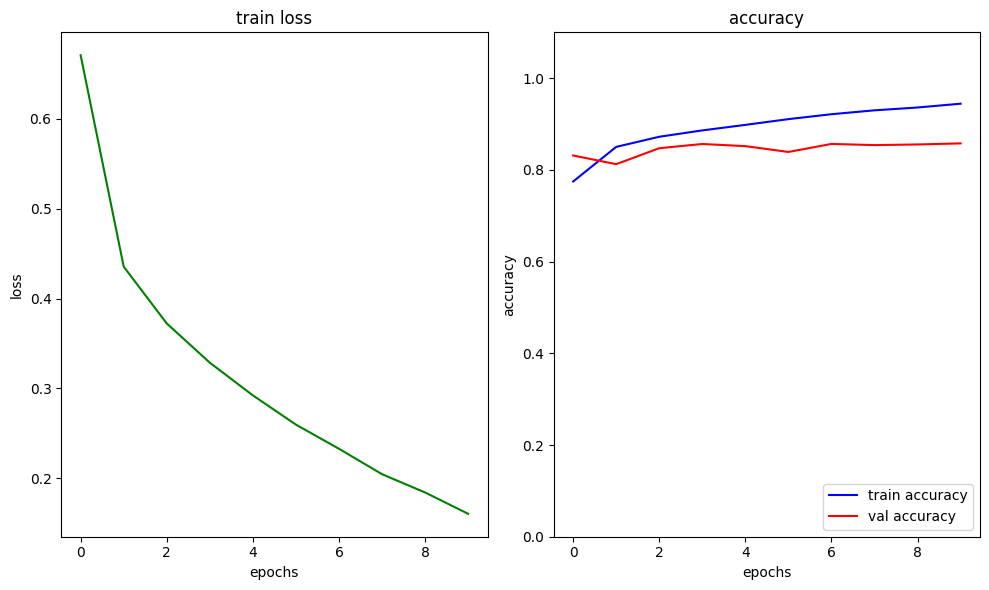

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers   import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
import numpy as np
import matplotlib.pyplot as plt

#1: 
##gpus = tf.config.experimental.list_physical_devices('GPU')
##tf.config.experimental.set_memory_growth(gpus[0], True)

#2
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') # (50000, 32, 32, 3)
x_test  = x_test.astype('float32')  # (10000, 32, 32, 3)

# one-hot encoding 
y_train = tf.keras.utils.to_categorical(y_train)
y_test  = tf.keras.utils.to_categorical(y_test)

# preprocessing, 'caffe', x_train, x_test: BGR
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

#3: resize_layer
inputs = Input(shape=(32, 32, 3))
resize_layer = tf.keras.layers.Lambda(lambda img: tf.image.resize(img,(224, 224)))(inputs) 

#4:
vgg_model = VGG16(
    weights='imagenet', 
    include_top= False, 
    input_tensor= resize_layer  # input_tensor= inputs
    )

vgg_model.trainable=False
                      
#4-1: output: classification
x = vgg_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output  = Dense(10, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=output)
model.summary()

#5: train and evaluate the model
#filepath = "RES/ckpt/4404-model.h5"
#cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath, verbose=0, save_best_only=True)
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
ret = model.fit(x_train, y_train, epochs=10, batch_size= 64, validation_split=0.3, verbose=2) #, callbacks = [cp_callback])
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

#6: plot accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].plot(ret.history['loss'],  "g-")
ax[0].set_title("train loss")
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')

ax[1].set_ylim(0, 1.1)
ax[1].plot(ret.history['accuracy'],     "b-", label="train accuracy")
ax[1].plot(ret.history['val_accuracy'], "r-", label="val accuracy")
ax[1].set_title("accuracy")
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
plt.legend(loc='lower right')
fig.tight_layout()
plt.show()

# Step46 - ResNet Model

https://paperswithcode.com/sota/image-classification-on-imagenet

## ResNet50 (264K, pre-trained)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 lambda_2 (Lambda)              (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['lambda_2[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                           

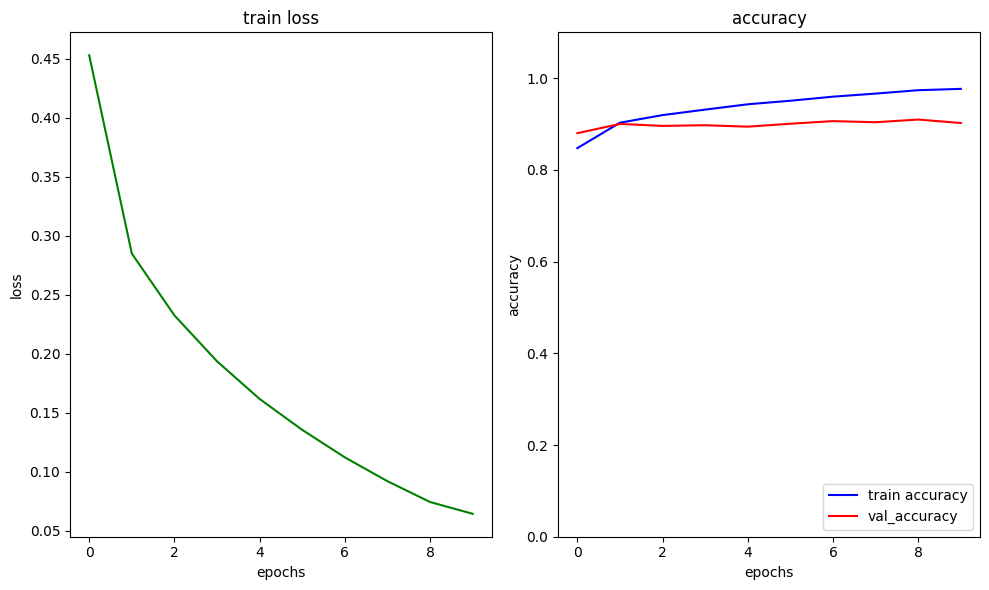

In [ ]:
''' 
ref1: https://keras.io/applications/
ref2:https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet_common.py
ref3:
https://github.com/keras-team/keras-applications/releases/tag/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
'''
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers   import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions 
from tensorflow.keras.preprocessing import image # pip install pillow

import numpy as np
import matplotlib.pyplot as plt

#1:
##import tensorflow as tf
##gpus = tf.config.experimental.list_physical_devices('GPU')
##tf.config.experimental.set_memory_growth(gpus[0], True)


#2
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')      # (50000, 32, 32, 3)
x_test = x_test.astype('float32')        # (10000, 32, 32, 3)

# one-hot encoding 
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# preprocessing, 'caffe', x_train, x_test: BGR
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

#3: resize_layer
inputs = Input(shape = (32, 32, 3))
resize_layer = tf.keras.layers.Lambda(lambda img: tf.image.resize(img,(224, 224)))(inputs)
res_model = ResNet50(weights = 'imagenet', include_top = False, input_tensor = resize_layer)
res_model.trainable=False

#4: create top for cifar10 classification
x = res_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
outs  = Dense(10, activation = 'softmax')(x)
model = tf.keras.Model(inputs = inputs, outputs=outs)
model.summary()

#5: train and evaluate the model
#filepath = "RES/ckpt/4603-model.h5"
#cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath, verbose = 0, save_best_only = True)
                 
opt = tf.keras.optimizers.RMSprop(learning_rate = 0.001)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
ret = model.fit(x_train, y_train, epochs = 10, batch_size = 64, validation_split = 0.3, verbose = 2) #, callbacks = [cp_callback])

y_pred = model.predict(x_train)
y_label = np.argmax(y_pred, axis = 1)
C = tf.math.confusion_matrix(np.argmax(y_train, axis = 1), y_label)
print("confusion_matrix(C):", C)
train_loss, train_acc = model.evaluate(x_train, y_train, verbose = 2)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose = 2)

#6: plot accuracy and loss
fig, ax = plt.subplots(1, 2, figsize = (10, 6))
ax[0].plot(ret.history['loss'], "g-")
ax[0].set_title("train loss")
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')

ax[1].set_ylim(0, 1.1)
ax[1].plot(ret.history['accuracy'], "b-", label = "train accuracy")
ax[1].plot(ret.history['val_accuracy'], "r-", label = "val_accuracy")
ax[1].set_title("accuracy")
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
plt.legend(loc = 'lower right')
fig.tight_layout()
plt.show()

## Huggingface

https://huggingface.co/docs/transformers/tasks/image_classification#image-classification


https://huggingface.co/datasets/cifar10



In [ ]:
!pip install transformers datasets evaluate

  Using cached transformers-4.28.1-py3-none-any.whl (7.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 7.2 MB/s eta 0:00:00
  Using cached filelock-3.12.0-py3-none-any.whl (10 kB)
  Using cached huggingface_hub-0.14.1-py3-none-any.whl (224 kB)
  Using cached regex-2023.5.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (769 kB)
  Using cached tokenizers-0.13.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.8 MB)
  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)
  Using cached pyarrow-12.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.9 MB)
  Using cached dill-0.3.6-py3-none-any.whl (110 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.0/154.0 kB 34.2 MB/s eta 0:00:00
  Using cache

In [ ]:
!pip install ipywidgets

  Using cached ipywidgets-8.0.6-py3-none-any.whl (138 kB)
  Using cached widgetsnbextension-4.0.7-py3-none-any.whl (2.1 MB)
  Using cached jupyterlab_widgets-3.0.7-py3-none-any.whl (198 kB)


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from datasets import load_dataset
from datasets import list_datasets
datasets_list = list_datasets()
datasets_list[datasets_list.index('cifar10')]

'cifar10'

In [ ]:
dataset_train = load_dataset('cifar10', split='train')
dataset_train = load_dataset('cifar10', split='test')
dataset_train_5000 = load_dataset("cifar10", split="train[:5000]")
dataset = load_dataset('cifar10')
print(dataset)

Found cached dataset cifar10 (/home/edward/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)
Found cached dataset cifar10 (/home/edward/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)
Found cached dataset cifar10 (/home/edward/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)
Found cached dataset cifar10 (/home/edward/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})


In [ ]:
splitted_dataset = dataset['train'].train_test_split(test_size=0.3)
splitted_dataset

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 35000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 15000
    })
})

In [ ]:
# image: a PIL image of the food item
# label: the label class of the food item
splitted_dataset["train"][0]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 3}

In [ ]:
splitted_dataset["train"].features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
labels = splitted_dataset["train"].features["label"].names
label2id = {i:label for i, label in enumerate(labels)}
id2label = {v:k for k, v in label2id.items()}

In [ ]:
label2id

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [ ]:
id2label

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [ ]:
from transformers import AutoImageProcessor
checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [ ]:
size = (image_processor.size["height"], image_processor.size["width"])
size

(224, 224)

In [ ]:
train_data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.Resizing(size[0], size[1]),
        tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ],
    name="train_data_augmentation",
)

val_data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.Resizing(size[0], size[1]),
        tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ],
    name="val_data_augmentation",
)

2023-05-08 02:21:28.805253: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 02:21:28.805726: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-08 02:21:28.805945: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-08 02:21:28.806082: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), bu

In [ ]:
from PIL import Image

def convert_to_tf_tensor(image: Image):
    np_image = np.array(image)
    tf_image = tf.convert_to_tensor(np_image)
    # `expand_dims()` is used to add a batch dimension since
    # the TF augmentation layers operates on batched inputs.
    return tf.expand_dims(tf_image, 0)

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    images = [
        train_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["img"]
    ]
    example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    images = [
        val_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["img"]
    ]
    example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)    

In [ ]:
splitted_dataset["train"].set_transform(preprocess_train)
splitted_dataset["test"].set_transform(preprocess_val)

In [ ]:
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator(return_tensors="tf")

In [ ]:
import evaluate
accuracy = evaluate.load("accuracy")
accuracy

EvaluationModule(name: "accuracy", module_type: "metric", features: {'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)}, usage: """
Args:
    predictions (`list` of `int`): Predicted labels.
    references (`list` of `int`): Ground truth labels.
    normalize (`boolean`): If set to False, returns the number of correctly classified samples. Otherwise, returns the fraction of correctly classified samples. Defaults to True.
    sample_weight (`list` of `float`): Sample weights Defaults to None.

Returns:
    accuracy (`float` or `int`): Accuracy score. Minimum possible value is 0. Maximum possible value is 1.0, or the number of examples input, if `normalize` is set to `True`.. A higher score means higher accuracy.

Examples:

    Example 1-A simple example
        >>> accuracy_metric = evaluate.load("accuracy")
        >>> results = accuracy_metric.compute(references=[0, 1, 2, 0, 1, 2], predictions=[0, 1, 1, 2, 1, 0])
        >>> print(results)
    

In [ ]:
from transformers import create_optimizer

batch_size = 16
num_epochs = 5
num_train_steps = len(splitted_dataset["train"]) * num_epochs
learning_rate = 3e-5
weight_decay_rate = 0.01
print(f'num_epochs: {num_epochs}, batch_size: {batch_size}, num_train_steps: {num_train_steps}, learning_rate: {learning_rate}')

optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=0,
)

num_epochs: 5, batch_size: 16, num_train_steps: 175000, learning_rate: 3e-05


In [ ]:
from transformers import TFAutoModelForImageClassification

model = TFAutoModelForImageClassification.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
)
model.summary()

2023-05-08 02:21:39.797521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-05-08 02:21:40.536843: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-08 02:21:40.590692: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some layers from the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing TFViTForImageClassification: ['vit/pooler/dense/kernel:0', 'vit/pooler/dense/bias:0']
- This IS expected if you are initializing TFViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from the checkpoint of a model that you expe

Model: "tf_vi_t_for_image_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  85798656  
                                                                 
 classifier (Dense)          multiple                  7690      
                                                                 
Total params: 85,806,346
Trainable params: 85,806,346
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# converting our train dataset to tf.data.Dataset
tf_train_dataset = splitted_dataset["train"].to_tf_dataset(
    columns=["pixel_values"], 
    label_cols=["label"], 
    shuffle=True, 
    batch_size=batch_size, 
    collate_fn=data_collator
)

# converting our test dataset to tf.data.Dataset
tf_eval_dataset = splitted_dataset["test"].to_tf_dataset(
    columns=["pixel_values"], 
    label_cols=["label"], 
    shuffle=True, 
    batch_size=batch_size, 
    collate_fn=data_collator
)

/home/edward/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/datasets/arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [ ]:
print('tf_train_dataset.element_spec', tf_train_dataset.element_spec) # (, 224, 224, 3)
print('tf_eval_dataset.element_spec', tf_eval_dataset.element_spec) # (, 224, 224, 3)
print('tf_train_dataset.cardinality', tf_train_dataset.cardinality().numpy()) 
print('tf_eval_dataset.cardinality', tf_eval_dataset.cardinality().numpy()) 

tf_train_dataset.element_spec (TensorSpec(shape=(None, 3, 224, 224), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
tf_eval_dataset.element_spec (TensorSpec(shape=(None, 3, 224, 224), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
tf_train_dataset.cardinality 2188
tf_eval_dataset.cardinality 938


In [ ]:
# def min_max(X, y_label):
#     return tf.image.per_image_standardization(X), y_label

# def resize(X, y_label, height=224, width=224):
#     resized_X = tf.image.resize(X, (height, width))
#     return resized_X, y_label

# X_train = splitted_dataset["train"]["pixel_values"]
# y_train = splitted_dataset["train"].features["label"]

# train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# train_ds = (train_ds
#         .map(min_max)
#         .map(resize)
# #        .map(self.to_categorical)
#         .shuffle(buffer_size=batch_size*4)
#         .prefetch(tf.data.AUTOTUNE)
#         .batch(batch_size=batch_size, drop_remainder=True))

# X_val = splitted_dataset["test"]["pixel_values"]
# y_val = splitted_dataset["test"].features["label"]

# val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
# val_ds = (val_ds
#         .map(min_max)
#         .map(resize)
# #        .map(self.to_categorical)
#         .shuffle(buffer_size=batch_size*4)
#         .prefetch(tf.data.AUTOTUNE)
#         .batch(batch_size=batch_size, drop_remainder=True))

In [ ]:
# print('train_ds.element_spec', train_ds.element_spec) # (, 224, 224, 3)
# print('val_ds.element_spec', val_ds.element_spec) # (, 224, 224, 3)
# print('tf_train_dataset.cardinality', tf_train_dataset.cardinality().numpy()) 
# print('val_ds.cardinality', val_ds.cardinality().numpy()) 

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss)

In [ ]:
from transformers.keras_callbacks import KerasMetricCallback, PushToHubCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_eval_dataset)
# push_to_hub_callback = PushToHubCallback(
#     output_dir="cifar10_classifier",
#     tokenizer=image_processor,
#     save_strategy="no",
# )
callbacks = [metric_callback]

In [ ]:
model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=num_epochs, callbacks=callbacks)

Epoch 1/5
2188/2188 [==============================] - 980s 445ms/step - loss: 0.4713 - val_loss: 0.1757 - accuracy: 0.9515
Epoch 2/5
2188/2188 [==============================] - 949s 434ms/step - loss: 0.0948 - val_loss: 0.1489 - accuracy: 0.9553
Epoch 3/5
2188/2188 [==============================] - 934s 427ms/step - loss: 0.0465 - val_loss: 0.1771 - accuracy: 0.9480
Epoch 4/5
2188/2188 [==============================] - 933s 426ms/step - loss: 0.0302 - val_loss: 0.1492 - accuracy: 0.9579
Epoch 5/5
2188/2188 [==============================] - 933s 427ms/step - loss: 0.0238 - val_loss: 0.1869 - accuracy: 0.9495


In [ ]:
test_dataset = dataset['test']
image = test_dataset["img"][0]

In [ ]:
test_data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.Resizing(size[0], size[1]),
        tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ],
    name="test_data_augmentation",
)

In [ ]:
def preprocess_test(example_batch):
    """Apply test_transforms across a batch."""
    images = [
        test_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["img"]
    ]
    example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch

In [ ]:
test_dataset.set_transform(preprocess_train)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......rescaling
.........vars
......resizing
.........vars
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-05-08 07:31:09          658
metadata.json                                  2023-05-08 07:31:09           64
variables.h5                                   2023-05-08 07:31:09         6336


In [ ]:
tf_test_dataset = test_dataset.to_tf_dataset(
    columns=["pixel_values"], 
    label_cols=["label"], 
    shuffle=True, 
    batch_size=batch_size, 
    collate_fn=data_collator
)

/home/edward/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/datasets/arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [ ]:
model.evaluate(tf_train_dataset)

2188/2188 [==============================] - 292s 134ms/step - loss: 0.0359


0.035935524851083755

In [ ]:
model.evaluate(tf_test_dataset)

625/625 [==============================] - 82s 132ms/step - loss: 0.2065


0.20653016865253448

In [ ]:
# from transformers import pipeline

# classifier = pipeline("image-classification", model="cifar10_classifier")
# classifier(image)
# from transformers import AutoImageProcessor

# image_processor = AutoImageProcessor.from_pretrained("YOUR_ID/cifar10_classifier")
# inputs = image_processor(image, return_tensors="tf")
# from transformers import TFAutoModelForImageClassification

# model = TFAutoModelForImageClassification.from_pretrained("YOUR_ID/cifar10_classifier")
# logits = model(**inputs).logits
# predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
# model.config.id2label[predicted_class_id]

In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image
import requests

url = 'https://www.cs.toronto.edu/~kriz/cifar-10-sample/dog10.png'
image = Image.open(requests.get(url, stream=True).raw)
feature_extractor = ViTFeatureExtractor.from_pretrained('nateraw/vit-base-patch16-224-cifar10')
model = ViTForImageClassification.from_pretrained('nateraw/vit-base-patch16-224-cifar10')
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
preds = outputs.logits.argmax(dim=1)

classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]
classes[preds[0]]